In [ ]:
# INSTALL REQUIRED PACKAGES

print(" Installing required packages")
# Upgrade pip
!pip install --upgrade pip --quiet

print("Installing scikit-learn")
!pip install scikit-learn==1.5.0 --quiet

# --- Skipped TA-Lib installation due to issues ---

# print("\nAttempting TA-Lib installation")
# !apt-get update -qq
# !apt-get install -y build-essential python3-dev ta-lib libta-lib0-dev --quiet
# !pip install TA-Lib --quiet

# --- Install scikeras for Keras-Scikit-learn integration ---
print("Installing scikeras for Keras-Scikit-learn integration")
!pip install scikeras[tensorflow] --quiet

# --- Install other core packages(order imp) ---
print("Installing other core Python packages")
!pip install yfinance tensorflow pandas numpy matplotlib seaborn plotly xgboost shap --quiet

print("\n All required packages installation attempts completed.")

# IMPORT ESSENTIAL LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')

# Data fetching library
import yfinance as yf

# For preprocessing and scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# For traditional ML models
from sklearn.svm import SVR
from xgboost import XGBRegressor

# For Deep Learning models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Import KerasRegressor from scikeras.wrappers
from scikeras.wrappers import KerasRegressor

# For model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# For hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# For explainability
import shap

#  Attempt to import TA-Lib here, it will fail gracefully if not installed
try:
    import talib as ta
    TALIB_AVAILABLE = True
    print("TA-Lib successfully imported for technical indicator calculations.")
except ImportError:
    TALIB_AVAILABLE = False
    print("TA-Lib not found. Manual calculations will be used for technical indicators.")


print("Essential libraries imported.")
print("-" * 50)
print("Setup Complete!")

 Installing required packages
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.8 MB/s eta 0:00:00
Installing scikit-learn
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 83.4 MB/s eta 0:00:00
Installing scikeras for Keras-Scikit-learn integration
Installing other core Python packages

 All required packages installation attempts completed.
TA-Lib not found. Manual calculations will be used for technical indicators.
Essential libraries imported.
--------------------------------------------------
Setup Complete!


In [ ]:
print("Data Collection Setup")
print("-" * 50)

# DATA COLLECTION FUNCTION

def collect_stock_data(symbol, period="2y", interval="1d"):
    """
    Collect stock data from Yahoo Finance.

    Parameters:
    - symbol: Stock symbol (e.g., 'AAPL', 'MSFT').
    - period: Time period (1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max).
    - interval: Data interval (1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo).

    Returns:
    - DataFrame with stock data, or None if an error occurs or no data is found.
    """
    try:
        print(f"Collecting data for {symbol} (Period: {period}, Interval: {interval})")

        ticker = yf.Ticker(symbol)

        data = ticker.history(period=period, interval=interval)

        if data.empty:
            print(f" No data found for {symbol} with the specified period/interval.")
            return None

        data.index = pd.to_datetime(data.index)
        data = data.sort_index()

        print(f"Successfully collected {len(data)} records for {symbol}.")
        print(f"Date range: {data.index.min().strftime('%Y-%m-%d')} to {data.index.max().strftime('%Y-%m-%d')}.")

        return data

    except Exception as e:
        print(f"Error collecting data for {symbol}: {str(e)}.")
        return None


# Define stocks to analyze
STOCK_SYMBOLS = [
    'AAPL',  # Apple
    'MSFT',  # Microsoft
    'GOOGL', # Google
    'AMZN',  # Amazon
    'TSLA'   # Tesla
]

PRIMARY_STOCK = 'AAPL'

print(f"\nCollecting data for the primary stock: {PRIMARY_STOCK}")
print("-" * 30)

stock_data = collect_stock_data(PRIMARY_STOCK, period="3y", interval="1d")

if stock_data is not None:
    print(f"\nData Overview for {PRIMARY_STOCK}:")
    print(f"Shape: {stock_data.shape}")
    print(f"Columns: {list(stock_data.columns)}")
    print("\nFirst 5 rows:")
    print(stock_data.head())

    print("\nLast 5 rows:")
    print(stock_data.tail())

    print("\nBasic Statistics:")
    print(stock_data.describe())
else:
    print("\n Failed to collect data for the primary stock. Please check your internet connection, stock symbol, or period/interval.")

print("\n Data Collection Successful!")

Data Collection Setup
--------------------------------------------------

------------------------------
Successfully collected 752 records for AAPL.
Date range: 2022-06-13 to 2025-06-11.

Data Overview for AAPL:
Shape: (752, 7)
Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']

First 5 rows:
                                 Open        High         Low       Close  \
Date                                                                        
2022-06-13 00:00:00-04:00  130.771996  133.065208  129.364583  129.797638   
2022-06-14 00:00:00-04:00  131.027895  131.775889  129.403939  130.663727   
2022-06-15 00:00:00-04:00  132.169551  135.171394  130.073194  133.291550   
2022-06-16 00:00:00-04:00  129.994503  130.299605  127.002495  128.006393   
2022-06-17 00:00:00-04:00  128.016233  130.978700  127.760329  129.482697   

                              Volume  Dividends  Stock Splits  
Date                                                           
2022-06

Data Quality Check
--------------------------------------------------
Performing quality check for AAPL

Missing Values Analysis:
  No missing values found.

 Data Completeness:
   Total records: 752
  Sufficient data for analysis.

 Data Consistency Checks:
   All price and volume values are non-negative.
  High/Low relationship is valid.
   Close prices are within High/Low range.

 Data Distribution Analysis:
  No extreme price changes detected (threshold: >50%).

 Date Continuity Check:
   No significant date gaps found.

 Quality Check Summary:
   Data quality is GOOD - Ready for preprocessing.


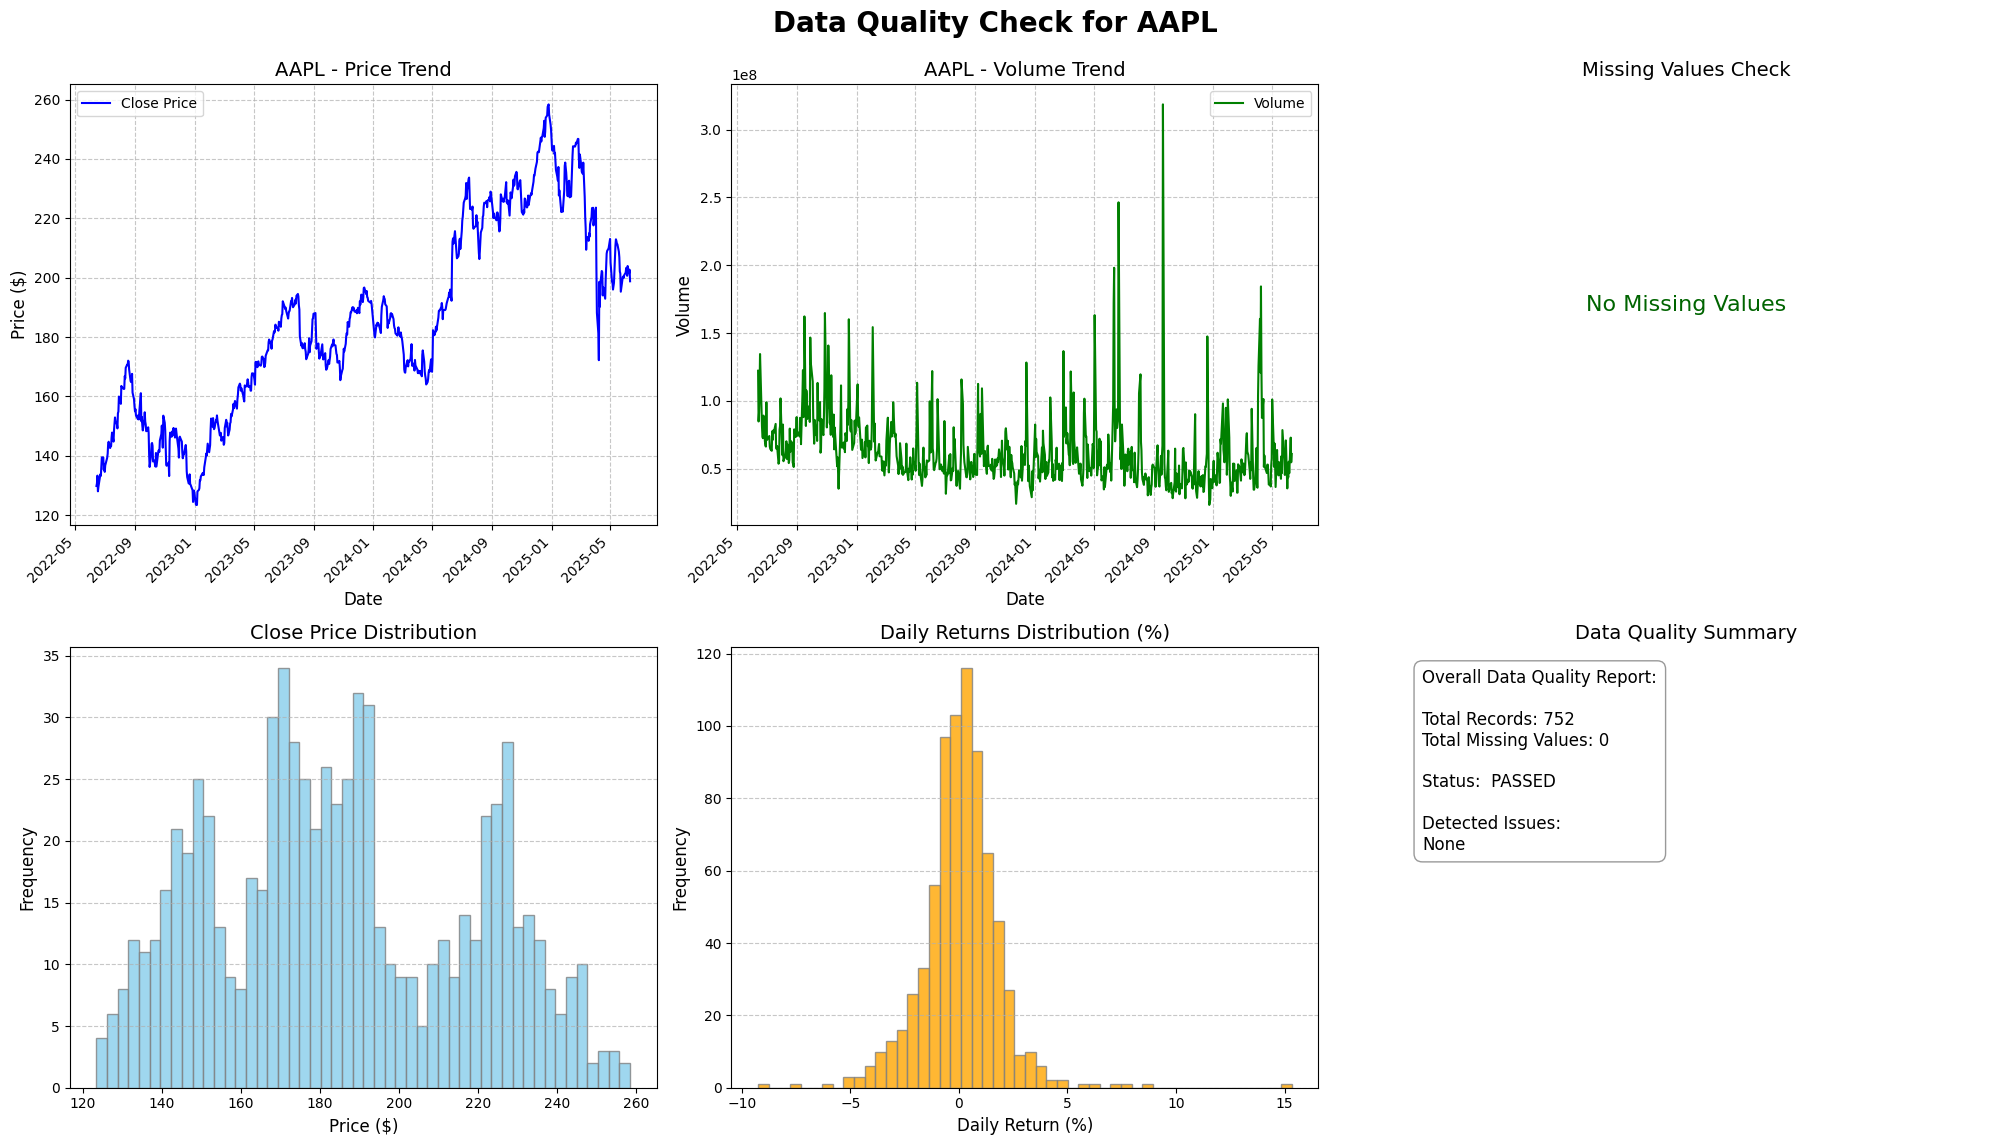


 Quality Check PASSED!
 Data is ready for preprocessing.
 Run Data Preprocessing.

--------------------------------------------------
  Data Quality Check Done!


In [ ]:
print("Data Quality Check")
print("-" * 50)

PROCEED_ON_QUALITY_ISSUES = False # <--- ADJUST THIS FLAG AS NEEDED

def perform_data_quality_check(data, symbol):
    """
    Perform comprehensive data quality checks.

    Parameters:
    - data: Stock data DataFrame.
    - symbol: Stock symbol for reporting.

    Returns:
    - quality_report: Dictionary with quality metrics.
    - is_quality_good: Boolean indicating if data passes quality checks.
    """

    quality_report = {}
    issues = []

    print(f"Performing quality check for {symbol}")

    missing_values = data.isnull().sum()
    missing_percentage = (missing_values / len(data)) * 100

    quality_report['missing_values'] = missing_values
    quality_report['missing_percentage'] = missing_percentage

    print("\nMissing Values Analysis:")
    if missing_values.sum() == 0:
        print("  No missing values found.")
    else:
        for col in data.columns:
            if missing_values[col] > 0:
                print(f"    {col}: {missing_values[col]} ({missing_percentage[col]:.2f}%) missing values detected.")
                issues.append(f"Missing values in {col}")


    # Data completeness
    total_records = len(data)
    quality_report['total_records'] = total_records

    print(f"\n Data Completeness:")
    print(f"   Total records: {total_records}")

    if total_records < 100: # threshold for sufficient data
        issues.append("Insufficient data (less than 100 records)")
        print("  Warning: Less than 100 records available for analysis.")
    else:
        print("  Sufficient data for analysis.")

    # Data consistency
    print(f"\n Data Consistency Checks:")

    price_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    negative_values_found = False
    for col in price_cols:
        if col in data.columns and (data[col] < 0).any().any():
            issues.append(f"Negative values found in {col}.")
            print(f"  Negative values detected in {col}.")
            negative_values_found = True
    if not negative_values_found:
        print("   All price and volume values are non-negative.")

    invalid_high_low = (data['High'] < data['Low']).sum()
    if invalid_high_low > 0:
        issues.append(f"{invalid_high_low} records with High < Low.")
        print(f"   {invalid_high_low} records with invalid High/Low relationship.")
    else:
        print("  High/Low relationship is valid.")

    close_out_of_range = ((data['Close'] > data['High']) | (data['Close'] < data['Low'])).sum()
    if close_out_of_range > 0:
        issues.append(f"{close_out_of_range} records with Close outside High/Low range.")
        print(f"   {close_out_of_range} records with Close outside High/Low range.")
    else:
        print("   Close prices are within High/Low range.")

    print(f"\n Data Distribution Analysis:")

    data_temp = data.copy()
    if not data_temp['Close'].shift(1).isnull().all():
        data_temp['Price_Change_Pct'] = (data_temp['Close'].pct_change() * 100)
        extreme_changes = (abs(data_temp['Price_Change_Pct']) > 50).sum()
        if extreme_changes > 0:
            print(f"    {extreme_changes} days with extreme price changes (>50%).")
            quality_report['extreme_changes'] = extreme_changes
            issues.append("Extreme price changes detected.")
        else:
            print("  No extreme price changes detected (threshold: >50%).")
    else:
        print("   Skipping extreme price change check due to insufficient data for pct_change (perhaps too few records).")


    # Date continuity
    print(f"\n Date Continuity Check:")
    date_gaps = []
    dates = data.index.to_list()

    for i in range(1, len(dates)):
        gap = (dates[i] - dates[i-1]).days
        if gap > 7:
            date_gaps.append(gap)

    if date_gaps:
        print(f"   Found {len(date_gaps)} significant date gaps (more than 7 days).")
        quality_report['date_gaps'] = date_gaps
        issues.append("Significant date gaps detected.")
    else:
        print("   No significant date gaps found.")

    quality_report['issues'] = issues
    is_quality_good = len(issues) == 0

    print(f"\n Quality Check Summary:")
    if is_quality_good:
        print("   Data quality is GOOD - Ready for preprocessing.")
    else:
        print("   Data quality issues detected:")
        for issue in issues:
            print(f"      - {issue}")

    return quality_report, is_quality_good

# PERFORM QUALITY CHECK

if 'stock_data' in locals() and stock_data is not None and 'PRIMARY_STOCK' in locals():
    quality_report, data_quality_passed = perform_data_quality_check(stock_data, PRIMARY_STOCK)

    plt.figure(figsize=(20, 12))

    # Price trends
    plt.subplot(2, 3, 1)
    plt.plot(stock_data.index, stock_data['Close'], label='Close Price', color='blue', linewidth=1.5)
    plt.title(f'{PRIMARY_STOCK} - Price Trend', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    plt.legend(fontsize=10)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Volume trends
    plt.subplot(2, 3, 2)
    plt.plot(stock_data.index, stock_data['Volume'], label='Volume', color='green', linewidth=1.5)
    plt.title(f'{PRIMARY_STOCK} - Volume Trend', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Volume', fontsize=12)
    plt.legend(fontsize=10)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Missing values heatmap
    plt.subplot(2, 3, 3)
    missing_data = stock_data.isnull()
    if missing_data.any().any():
        sns.heatmap(missing_data, cbar=True, yticklabels=False, cmap='viridis')
        plt.title('Missing Values Heatmap', fontsize=14)
    else:
        plt.text(0.5, 0.5, 'No Missing Values', ha='center', va='center', fontsize=16, color='darkgreen')
        plt.title('Missing Values Check', fontsize=14)
        plt.axis('off')

    # Price distribution
    plt.subplot(2, 3, 4)
    plt.hist(stock_data['Close'].dropna(), bins=50, alpha=0.8, color='skyblue', edgecolor='gray')
    plt.title('Close Price Distribution', fontsize=14)
    plt.xlabel('Price ($)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Daily returns distribution
    plt.subplot(2, 3, 5)
    daily_returns = stock_data['Close'].pct_change().dropna() * 100
    plt.hist(daily_returns, bins=50, alpha=0.8, color='orange', edgecolor='gray')
    plt.title('Daily Returns Distribution (%)', fontsize=14)
    plt.xlabel('Daily Return (%)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Quality summary (text based)
    plt.subplot(2, 3, 6)
    plt.axis('off')

    issues_list_formatted = '- ' + '\n- '.join(quality_report['issues']) if quality_report['issues'] else 'None'

    quality_text = (
        "Overall Data Quality Report:\n\n"
        f"Total Records: {quality_report['total_records']}\n"
        f"Total Missing Values: {quality_report['missing_values'].sum()}\n\n"
        f"Status: {' PASSED' if data_quality_passed else 'ISSUES FOUND'}\n\n"
        "Detected Issues:\n"
        f"{issues_list_formatted}\n"
    )

    plt.text(0.05, 0.95, quality_text.strip(), fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", lw=1, alpha=0.8))
    plt.title('Data Quality Summary', fontsize=14)


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(f'Data Quality Check for {PRIMARY_STOCK}', fontsize=20, fontweight='bold', y=0.98) # Main title
    plt.show()

    if data_quality_passed:
        print("\n Quality Check PASSED!")
        print(" Data is ready for preprocessing.")
        print(" Run Data Preprocessing.")
    else:
        print("\n  Quality Check FAILED!")
        print(" Data quality issues detected. Please review the report above.")
        if PROCEED_ON_QUALITY_ISSUES:
            print("AUTOMATICALLY PROCEEDING due to 'PROCEED_ON_QUALITY_ISSUES' flag being True.")
            print(" Run  Data Preprocessing.")
        else:
            print("Execution stopped. Please address data quality issues or set 'PROCEED_ON_QUALITY_ISSUES = True' to continue.")


else:
    print(" No 'stock_data' available. Please ensure Step 1 was executed successfully.")

print("\n" + "-"*50)
print("  Data Quality Check Done!")

 Data Preprocessing
--------------------------------------------------
 TA-Lib not available. Using manual indicator calculations.

 Starting preprocessing pipeline
 Cleaning and normalizing data
   Removed 0 duplicate entries.
   Fixed 0 missing values.
 Data cleaning completed.
 Calculating technical indicators
   Using manual calculations
   Calculating custom indicators
 Calculated 23 technical indicators.
 Creating lagged features
 Created lagged features for periods: [1, 2, 3, 5, 10].
 Preparing features for machine learning
   Removed 49 rows with NaN values (from indicators/lags).
   Final dataset size after cleaning: 703 rows.
   Selected 53 features.
   Sample feature columns: ['SMA_10', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26']...['Volatility_lag_1', 'Volatility_lag_2', 'Volatility_lag_3', 'Volatility_lag_5', 'Volatility_lag_10'].
    Features scaled using StandardScaler.
  Target variable 'y' scaled using MinMaxScaler.
 Features and target prepared and scaled.

 Preprocessing

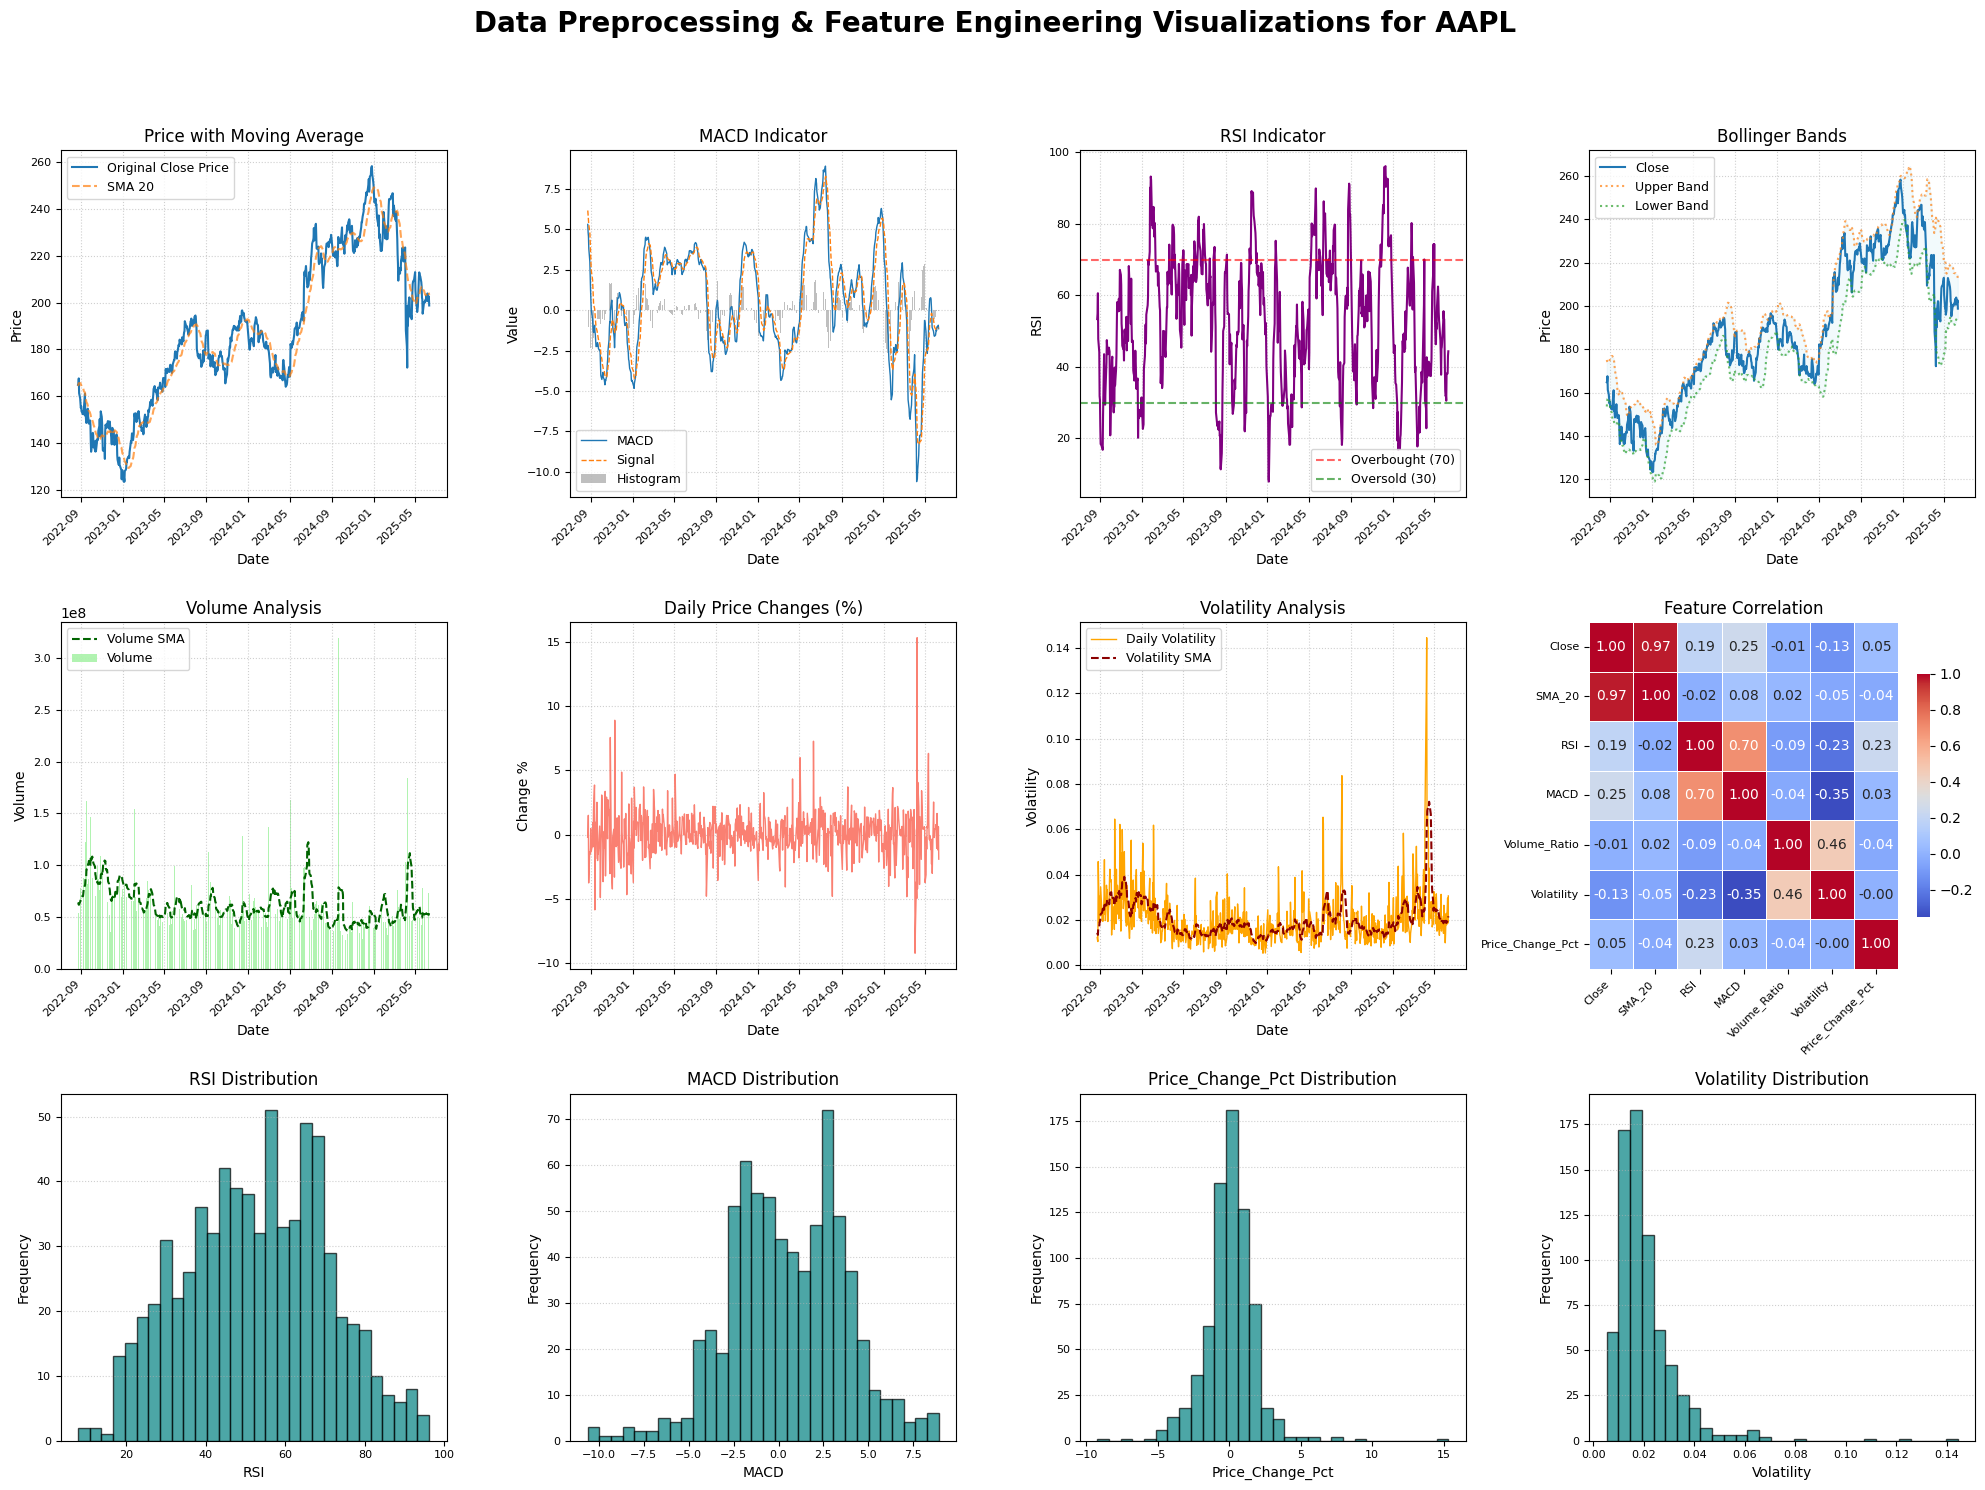


 Data Preprocessing Successful!
 Data is ready for model training.

--------------------------------------------------
 Preprocessing  Done!


In [ ]:
print(" Data Preprocessing")
print("-" * 50)

# Import TA-Lib (optional, if not installed globally)
try:
    import talib as ta
    TALIB_AVAILABLE = True
    print(" TA-Lib imported successfully.")
except ImportError:
    TALIB_AVAILABLE = False
    print(" TA-Lib not available. Using manual indicator calculations.")

def clean_and_normalize_data(data):
    """
    Clean and normalize the stock data.

    Parameters:
    - data: Raw stock data DataFrame.

    Returns:
    - cleaned_data: Cleaned DataFrame.
    """
    print(" Cleaning and normalizing data")

    cleaned_data = data.copy()

    cleaned_data = cleaned_data[~cleaned_data.index.duplicated(keep='first')]
    print(f"   Removed {len(data) - len(cleaned_data)} duplicate entries.")

    missing_before = cleaned_data.isnull().sum().sum()
    cleaned_data = cleaned_data.fillna(method='ffill')
    cleaned_data = cleaned_data.fillna(method='bfill')
    missing_after = cleaned_data.isnull().sum().sum()
    print(f"   Fixed {missing_before - missing_after} missing values.")

    cleaned_data = cleaned_data.sort_index()

    print(" Data cleaning completed.")
    return cleaned_data

def calculate_technical_indicators(data):
    """
    Calculate technical indicators like MACD, RSI, Moving Averages.

    Parameters:
    - data: Cleaned stock data DataFrame.

    Returns:
    - data_with_indicators: DataFrame with technical indicators.
    """
    print(" Calculating technical indicators")

    df = data.copy()
    close_prices = df['Close'].values
    high_prices = df['High'].values
    low_prices = df['Low'].values
    volume = df['Volume'].values

    if TALIB_AVAILABLE:
        print("   Using TA-Lib for calculations")
        df['SMA_10'] = ta.SMA(close_prices, timeperiod=10)
        df['SMA_20'] = ta.SMA(close_prices, timeperiod=20)
        df['SMA_50'] = ta.SMA(close_prices, timeperiod=50)
        df['EMA_12'] = ta.EMA(close_prices, timeperiod=12)
        df['EMA_26'] = ta.EMA(close_prices, timeperiod=26)
        df['MACD'], df['MACD_Signal'], df['MACD_Histogram'] = ta.MACD(close_prices)
        df['RSI'] = ta.RSI(close_prices, timeperiod=14)
        df['BB_Upper'], df['BB_Middle'], df['BB_Lower'] = ta.BBANDS(close_prices)
        df['Stoch_K'], df['Stoch_D'] = ta.STOCH(high_prices, low_prices, close_prices)
        df['Williams_R'] = ta.WILLR(high_prices, low_prices, close_prices)
    else:
        print("   Using manual calculations")
        df['SMA_10'] = df['Close'].rolling(window=10).mean()
        df['SMA_20'] = df['Close'].rolling(window=20).mean()
        df['SMA_50'] = df['Close'].rolling(window=50).mean()
        df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
        df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = df['EMA_12'] - df['EMA_26']
        df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
        df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))
        df['BB_Middle'] = df['Close'].rolling(window=20).mean()
        bb_std = df['Close'].rolling(window=20).std()
        df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
        df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)

    print("   Calculating custom indicators")
    df['High_Low_Ratio'] = df['High'] / df['Low']
    df['Close_Open_Ratio'] = df['Close'] / df['Open']
    df['Price_Change'] = df['Close'].diff()
    df['Price_Change_Pct'] = df['Close'].pct_change() * 100
    df['Volume_SMA_10'] = df['Volume'].rolling(window=10).mean()

    df['Volume_Ratio'] = df['Volume'] / df['Volume_SMA_10'].replace(0, np.nan)
    df['Volatility'] = (df['High'] - df['Low']) / df['Close']
    df['Volatility_SMA'] = df['Volatility'].rolling(window=10).mean()
    df['Price_Position'] = (df['Close'] - df['Low']) / (df['High'] - df['Low']).replace(0, np.nan) # division by zero
    df['Gap'] = df['Open'] - df['Close'].shift(1)
    df['Gap_Pct'] = (df['Gap'] / df['Close'].shift(1)).replace(0, np.nan) * 100 # division by zero

    print(f" Calculated {len([col for col in df.columns if col not in data.columns])} technical indicators.")

    return df

def create_lagged_features(data, lag_periods=[1, 2, 3, 5, 10]):
    """
    Create lagged features for time series analysis.

    Parameters:
    - data: DataFrame with technical indicators.
    - lag_periods: List of lag periods to create.

    Returns:
    - data_with_lags: DataFrame with lagged features.
    """
    print(" Creating lagged features")

    df = data.copy()
    key_features = ['Close', 'Volume', 'RSI', 'MACD', 'Price_Change_Pct', 'Volatility']

    for feature in key_features:
        if feature in df.columns:
            for lag in lag_periods:
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

    print(f" Created lagged features for periods: {lag_periods}.")
    return df

def prepare_features_for_ml(data, target_column='Close', time_steps=30):
    """
    Prepare features and target for machine learning models, including scaling.

    Parameters:
    - data: DataFrame with all features.
    - target_column: Name of target variable.
    - time_steps: Number of time steps for sequence data (for LSTM/CNN).

    Returns:
    - X_scaled: Feature matrix (scaled) for traditional ML.
    - y_scaled: Target vector (scaled) for traditional ML.
    - feature_names: List of feature names.
    - feature_scaler: Fitted StandardScaler object for features.
    - scaler_y: Fitted MinMaxScaler object for target.
    - final_data_processed: Final cleaned DataFrame (after dropping NaNs).
    """
    print(" Preparing features for machine learning")

    df_clean = data.dropna()
    print(f"   Removed {len(data) - len(df_clean)} rows with NaN values (from indicators/lags).")
    print(f"   Final dataset size after cleaning: {len(df_clean)} rows.")

    exclude_columns = [target_column, 'Open', 'High', 'Low', 'Adj Close', 'Volume', 'Dividends', 'Stock Splits']
    feature_columns = [col for col in df_clean.columns if col not in exclude_columns and 'Unnamed' not in col]

    if not feature_columns:
        raise ValueError("No valid features remaining after exclusion. Check exclude_columns or data.")

    X = df_clean[feature_columns]
    y = df_clean[target_column]

    print(f"   Selected {len(feature_columns)} features.")
    print(f"   Sample feature columns: {feature_columns[:5]}...{feature_columns[-5:] if len(feature_columns) > 5 else ''}.")

    # Scale features
    feature_scaler = StandardScaler()
    X_scaled = feature_scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=feature_columns, index=df_clean.index)
    print("    Features scaled using StandardScaler.")

    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()
    y_scaled = pd.Series(y_scaled, index=y.index)
    print("  Target variable 'y' scaled using MinMaxScaler.")


    print(" Features and target prepared and scaled.")

    return X_scaled, y_scaled, feature_columns, feature_scaler, scaler_y, df_clean

#  PREPROCESSING PIPELINE

if 'stock_data' in locals() and stock_data is not None:
    print("\n Starting preprocessing pipeline")

    cleaned_data = clean_and_normalize_data(stock_data)

    data_with_indicators = calculate_technical_indicators(cleaned_data)

    data_with_lags = create_lagged_features(data_with_indicators)

    X, y, feature_names, feature_scaler, scaler_y, final_data = \
        prepare_features_for_ml(data_with_lags, target_column='Close')

    print("\n Preprocessing Results:")
    print(f"   Original data shape: {stock_data.shape}")
    print(f"   Final processed data shape (after NaN removal): {final_data.shape}")
    print(f"   Features (X) shape (scaled): {X.shape}")
    print(f"   Target (y) shape (scaled): {y.shape}")
    print(f"   Number of features: {len(feature_names)}")

    print("\n Sample of processed features (scaled):")
    print(X.head())

    print("\n Sample of target values (scaled):")
    print(y.head())

 # Visualization Preprocessing Results

    plt.figure(figsize=(20, 15))

    #  Original vs processed price data
    plt.subplot(3, 4, 1)
    if 'Close' in final_data.columns and 'SMA_20' in final_data.columns:
        plt.plot(final_data.index, final_data['Close'], label='Original Close Price', linewidth=1.5)
        plt.plot(final_data.index, final_data['SMA_20'], label='SMA 20', alpha=0.7, linestyle='--')
        plt.title('Price with Moving Average', fontsize=12)
        plt.xlabel('Date', fontsize=10)
        plt.ylabel('Price', fontsize=10)
        plt.legend(fontsize=9)
        plt.xticks(rotation=45, ha='right', fontsize=8)
        plt.yticks(fontsize=8)
        plt.grid(True, linestyle=':', alpha=0.6)
    else:
        plt.text(0.5, 0.5, 'Close/SMA_20 not available.', ha='center', va='center', fontsize=10)
        plt.title('Price with Moving Average (N/A)', fontsize=12)
        plt.axis('off')

    # MACD
    plt.subplot(3, 4, 2)
    if 'MACD' in final_data.columns and 'MACD_Signal' in final_data.columns:
        plt.plot(final_data.index, final_data['MACD'], label='MACD', linewidth=1)
        plt.plot(final_data.index, final_data['MACD_Signal'], label='Signal', linestyle='--', linewidth=1)
        plt.bar(final_data.index, final_data['MACD_Histogram'], label='Histogram', color='gray', alpha=0.5)
        plt.title('MACD Indicator', fontsize=12)
        plt.xlabel('Date', fontsize=10)
        plt.ylabel('Value', fontsize=10)
        plt.legend(fontsize=9)
        plt.xticks(rotation=45, ha='right', fontsize=8)
        plt.yticks(fontsize=8)
        plt.grid(True, linestyle=':', alpha=0.6)
    else:
        plt.text(0.5, 0.5, 'MACD not available.', ha='center', va='center', fontsize=10)
        plt.title('MACD Indicator (N/A)', fontsize=12)
        plt.axis('off')


    # RSI
    plt.subplot(3, 4, 3)
    if 'RSI' in final_data.columns:
        plt.plot(final_data.index, final_data['RSI'], linewidth=1.5, color='purple')
        plt.axhline(y=70, color='r', linestyle='--', alpha=0.6, label='Overbought (70)')
        plt.axhline(y=30, color='g', linestyle='--', alpha=0.6, label='Oversold (30)')
        plt.title('RSI Indicator', fontsize=12)
        plt.xlabel('Date', fontsize=10)
        plt.ylabel('RSI', fontsize=10)
        plt.legend(fontsize=9)
        plt.xticks(rotation=45, ha='right', fontsize=8)
        plt.yticks(fontsize=8)
        plt.grid(True, linestyle=':', alpha=0.6)
    else:
        plt.text(0.5, 0.5, 'RSI not available.', ha='center', va='center', fontsize=10)
        plt.title('RSI Indicator (N/A)', fontsize=12)
        plt.axis('off')

    # Bollinger Bands
    plt.subplot(3, 4, 4)
    if all(col in final_data.columns for col in ['Close', 'BB_Upper', 'BB_Lower']):
        plt.plot(final_data.index, final_data['Close'], label='Close', linewidth=1.5)
        plt.plot(final_data.index, final_data['BB_Upper'], label='Upper Band', alpha=0.7, linestyle=':')
        plt.plot(final_data.index, final_data['BB_Lower'], label='Lower Band', alpha=0.7, linestyle=':')
        plt.fill_between(final_data.index, final_data['BB_Upper'], final_data['BB_Lower'], color='skyblue', alpha=0.1)
        plt.title('Bollinger Bands', fontsize=12)
        plt.xlabel('Date', fontsize=10)
        plt.ylabel('Price', fontsize=10)
        plt.legend(fontsize=9)
        plt.xticks(rotation=45, ha='right', fontsize=8)
        plt.yticks(fontsize=8)
        plt.grid(True, linestyle=':', alpha=0.6)
    else:
        plt.text(0.5, 0.5, 'Bollinger Bands not available.', ha='center', va='center', fontsize=10)
        plt.title('Bollinger Bands (N/A)', fontsize=12)
        plt.axis('off')

    #Volume analysis
    plt.subplot(3, 4, 5)
    if 'Volume' in final_data.columns and 'Volume_SMA_10' in final_data.columns:
        plt.bar(final_data.index, final_data['Volume'], label='Volume', color='lightgreen', alpha=0.7)
        plt.plot(final_data.index, final_data['Volume_SMA_10'], label='Volume SMA', color='darkgreen', linestyle='--')
        plt.title('Volume Analysis', fontsize=12)
        plt.xlabel('Date', fontsize=10)
        plt.ylabel('Volume', fontsize=10)
        plt.legend(fontsize=9)
        plt.xticks(rotation=45, ha='right', fontsize=8)
        plt.yticks(fontsize=8)
        plt.grid(True, linestyle=':', alpha=0.6)
    else:
        plt.text(0.5, 0.5, 'Volume/Volume SMA not available.', ha='center', va='center', fontsize=10)
        plt.title('Volume Analysis (N/A)', fontsize=12)
        plt.axis('off')


    # Price changes
    plt.subplot(3, 4, 6)
    if 'Price_Change_Pct' in final_data.columns:
        plt.plot(final_data.index, final_data['Price_Change_Pct'], color='salmon', linewidth=1)
        plt.title('Daily Price Changes (%)', fontsize=12)
        plt.xlabel('Date', fontsize=10)
        plt.ylabel('Change %', fontsize=10)
        plt.xticks(rotation=45, ha='right', fontsize=8)
        plt.yticks(fontsize=8)
        plt.grid(True, linestyle=':', alpha=0.6)
    else:
        plt.text(0.5, 0.5, 'Price_Change_Pct not available.', ha='center', va='center', fontsize=10)
        plt.title('Daily Price Changes (%) (N/A)', fontsize=12)
        plt.axis('off')

    # Volatility
    plt.subplot(3, 4, 7)
    if 'Volatility' in final_data.columns and 'Volatility_SMA' in final_data.columns:
        plt.plot(final_data.index, final_data['Volatility'], label='Daily Volatility', color='orange', linewidth=1)
        plt.plot(final_data.index, final_data['Volatility_SMA'], label='Volatility SMA', color='darkred', linestyle='--')
        plt.title('Volatility Analysis', fontsize=12)
        plt.xlabel('Date', fontsize=10)
        plt.ylabel('Volatility', fontsize=10)
        plt.legend(fontsize=9)
        plt.xticks(rotation=45, ha='right', fontsize=8)
        plt.yticks(fontsize=8)
        plt.grid(True, linestyle=':', alpha=0.6)
    else:
        plt.text(0.5, 0.5, 'Volatility not available.', ha='center', va='center', fontsize=10)
        plt.title('Volatility Analysis (N/A)', fontsize=12)
        plt.axis('off')

    #  Feature correlation heatmap
    plt.subplot(3, 4, 8)

    plot_features = ['Close', 'SMA_20', 'RSI', 'MACD', 'Volume_Ratio', 'Volatility', 'Price_Change_Pct']
    available_plot_features = [f for f in plot_features if f in final_data.columns]
    if len(available_plot_features) >= 2: # Need at least 2 features for a correlation matrix
        corr_matrix = final_data[available_plot_features].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar_kws={"shrink": .7})
        plt.title('Feature Correlation', fontsize=12)
        plt.xticks(fontsize=8, rotation=45, ha='right')
        plt.yticks(fontsize=8, rotation=0)
    else:
        plt.text(0.5, 0.5, 'Not enough features for correlation plot.', ha='center', va='center', fontsize=10)
        plt.title('Feature Correlation (N/A)', fontsize=12)
        plt.axis('off')


    # Feature distributions for selected features
    feature_cols_for_dist = ['RSI', 'MACD', 'Price_Change_Pct', 'Volatility']
    for i, col in enumerate(feature_cols_for_dist, 9):
        plt.subplot(3, 4, i)
        if col in final_data.columns:
            plt.hist(final_data[col].dropna(), bins=30, alpha=0.7, color='teal', edgecolor='black')
            plt.title(f'{col} Distribution', fontsize=12)
            plt.xlabel(col, fontsize=10)
            plt.ylabel('Frequency', fontsize=10)
            plt.xticks(fontsize=8)
            plt.yticks(fontsize=8)
            plt.grid(axis='y', linestyle=':', alpha=0.6)
        else:
            plt.text(0.5, 0.5, f'{col} not found.', ha='center', va='center', fontsize=10)
            plt.title(f'{col} Distribution (N/A)', fontsize=12)
            plt.axis('off')

    plt.suptitle(f'Data Preprocessing & Feature Engineering Visualizations for {PRIMARY_STOCK}', fontsize=20, fontweight='bold', y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

    print("\n Data Preprocessing Successful!")
    print(" Data is ready for model training.")
else:
    print(" No 'stock_data' available. Please run Steps 1 and 2 first.")

print("\n" + "-"*50)
print(" Preprocessing  Done!")

 Model Selection and Training
--------------------------------------------------

 Starting initial model training pipeline...

 Training models for AAPL
   Traditional ML data splits: X_train:(562, 53), X_test:(141, 53).
   Time series data prepared: X_series shape (673, 30, 53), y_series shape (673,).
   Time Series data splits: X_train_series:(538, 30, 53), X_test_series:(135, 30, 53).

 Training XGBoost model...
 XGBoost trained - MSE: 0.0058, MAE: 0.0605, R2: 0.7060

 Training SVM model...
 SVM trained - MSE: 0.0974, MAE: 0.2808, R2: -3.9169

 Training LSTM model...
   LSTM model built and compiled.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
 LSTM trained - MSE: 12.7475, MAE: 1.8838, R2: -616.7199

 Training CNN model...
   CNN model built and compiled.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
 CNN trained - MSE: 0.0976, MAE: 0.2393, R2: -3.7301

 Visualizing initial model performance...


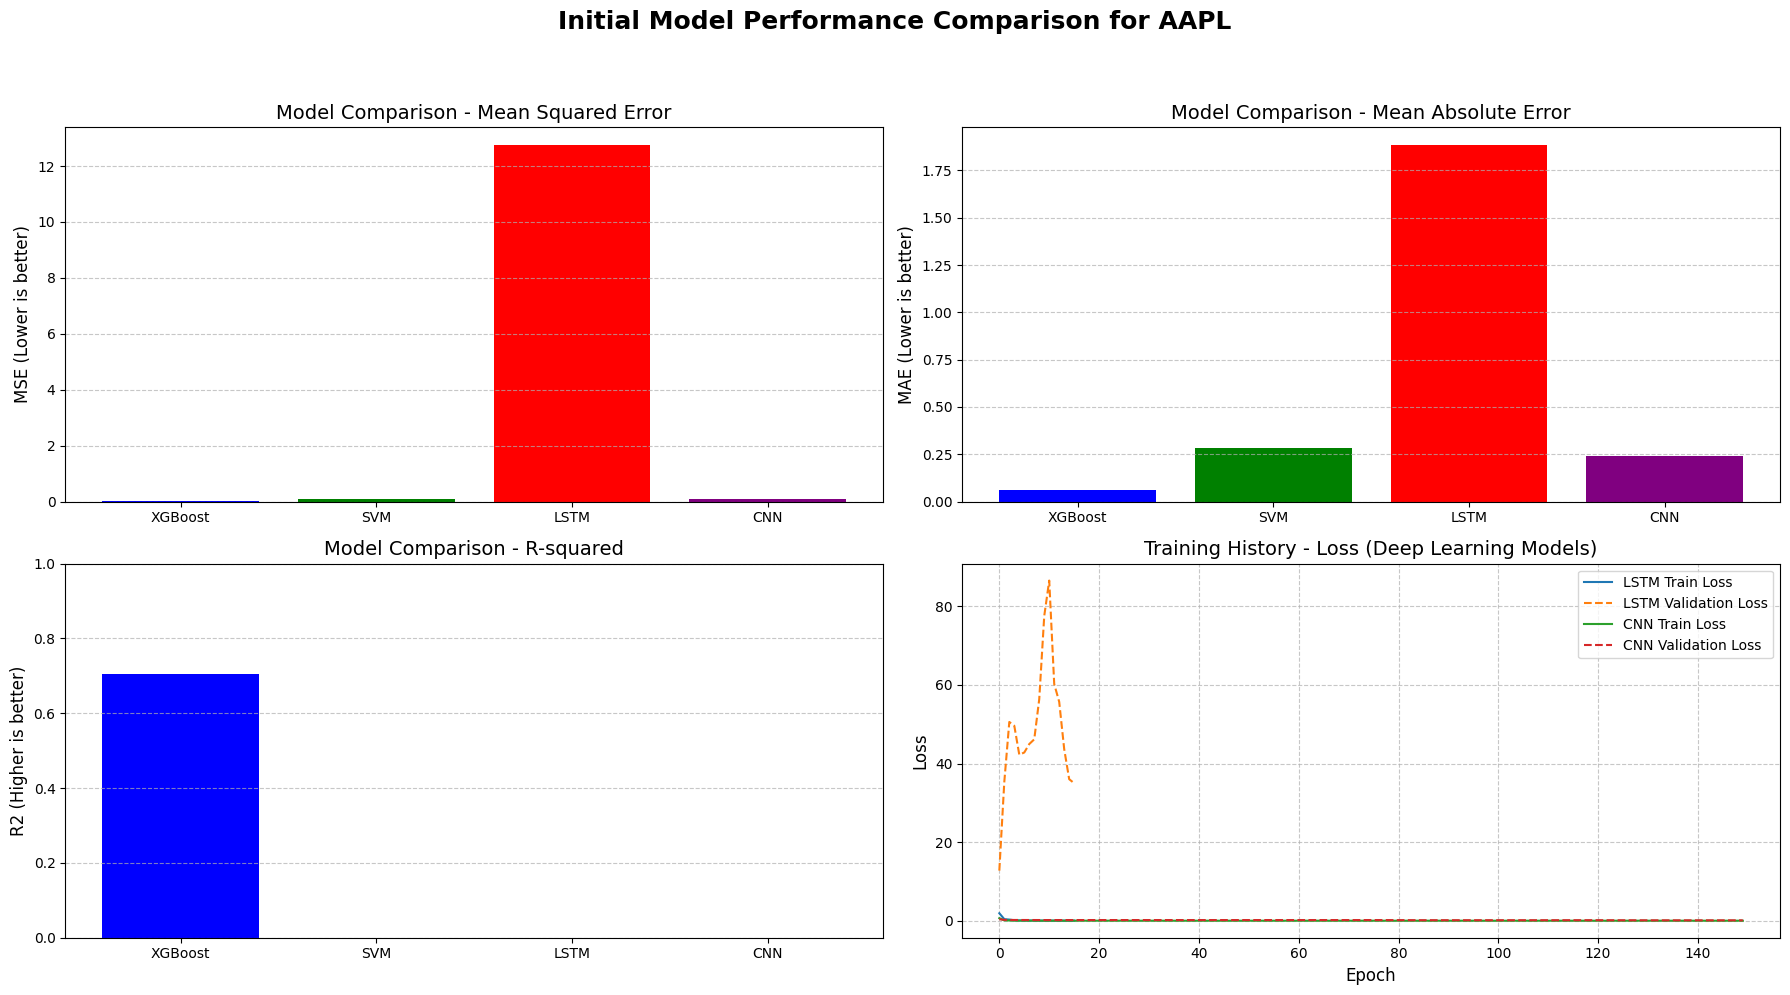


 Initial Model Performance Summary:

XGBoost:
  MSE: 0.0058
  MAE: 0.0605
  R2: 0.7060

SVM:
  MSE: 0.0974
  MAE: 0.2808
  R2: -3.9169

LSTM:
  MSE: 12.7475
  MAE: 1.8838
  R2: -616.7199

CNN:
  MSE: 0.0976
  MAE: 0.2393
  R2: -3.7301

  Initial Model Training and Evaluation Successful!

--------------------------------------------------


In [ ]:
print(" Model Selection and Training")
print("-" * 50)

# DATA PREPARATION FOR  MODELS (LSTM/CNN)
def prepare_time_series_data(X, y, time_steps=30):
    """
    Prepare time series data for LSTM/CNN models.

    Parameters:
    - X: Feature matrix (pandas DataFrame or numpy array).
    - y: Target vector (pandas Series or numpy array).
    - time_steps: Number of time steps to use for each sample.

    Returns:
    - X_series: Reshaped feature array for time series models (3D).
    - y_series: Corresponding target values.
    """
    X_series, y_series = [], []
    X_np = X.values if isinstance(X, pd.DataFrame) else X
    y_np = y.values if isinstance(y, pd.Series) else y

    for i in range(time_steps, len(X_np)):
        X_series.append(X_np[i-time_steps:i])
        y_series.append(y_np[i])

    X_series = np.array(X_series)
    y_series = np.array(y_series)

    print(f"   Time series data prepared: X_series shape {X_series.shape}, y_series shape {y_series.shape}.")
    return X_series, y_series

# DEEP LEARNING MODEL ARCHITECTURES
def build_lstm_model(input_shape):
    """
    Build and compile an LSTM model.

    Parameters:
    - input_shape: Shape of input data (timesteps, features).

    Returns:
    - model: Compiled LSTM model.
    """
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape, activation='relu', kernel_initializer='he_normal'),
        Dropout(0.2),
        LSTM(32, return_sequences=False, activation='relu', kernel_initializer='he_normal'),
        Dropout(0.2),
        Dense(16, activation='relu', kernel_initializer='he_normal'),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=['mae'])
    print("   LSTM model built and compiled.")
    return model

def build_cnn_model(input_shape):
    """
    Build and compile a CNN model for time series.

    Parameters:
    - input_shape: Shape of input data (timesteps, features).

    Returns:
    - model: Compiled CNN model.
    """
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, kernel_initializer='he_normal'),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=32, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(50, activation='relu', kernel_initializer='he_normal'),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=['mae'])
    print("   CNN model built and compiled.")
    return model

# MODEL TRAINING AND EVALUATION FUNCTION
def train_evaluate_models(X, y, primary_stock):
    """
    Train and evaluate multiple models (XGBoost, SVM, LSTM, CNN).

    Parameters:
    - X: Feature matrix (DataFrame).
    - y: Target vector (Series).
    - primary_stock: Stock symbol for reporting.

    Returns:
    - results: Dictionary with model performance metrics.
    - models: Dictionary with trained models.
    - X_train, X_test, y_train, y_test: Split data for traditional ML models (global scope).
    - X_train_series, X_test_series, y_train_series, y_test_series: Split data for DL models (global scope).
    """
    print(f"\n Training models for {primary_stock}")

    # 1. Prepare data for traditional ML models (Standard Split)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False, random_state=42
    )
    print(f"   Traditional ML data splits: X_train:{X_train.shape}, X_test:{X_test.shape}.")



    global time_steps
    time_steps = 30

    X_series, y_series = prepare_time_series_data(X, y, time_steps)


    split_idx_series = int(0.8 * len(X_series)) # 80% for training, 20% for testing

    X_train_series, X_test_series = X_series[:split_idx_series], X_series[split_idx_series:]
    y_train_series, y_test_series = y_series[:split_idx_series], y_series[split_idx_series:]
    print(f"   Time Series data splits: X_train_series:{X_train_series.shape}, X_test_series:{X_test_series.shape}.")


    results = {}
    models = {}

    # 1. Train and evaluate XGBoost
    print("\n Training XGBoost model...")

    xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5,
                             subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1,
                             tree_method='hist',
                             eval_metric='rmse',
                             objective='reg:squarederror'
                            )

    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)
    xgb_mse = mean_squared_error(y_test, xgb_pred)
    xgb_mae = mean_absolute_error(y_test, xgb_pred)
    xgb_r2 = r2_score(y_test, xgb_pred)

    results['XGBoost'] = {'MSE': xgb_mse, 'MAE': xgb_mae, 'R2': xgb_r2}
    models['XGBoost'] = xgb_model
    print(f" XGBoost trained - MSE: {xgb_mse:.4f}, MAE: {xgb_mae:.4f}, R2: {xgb_r2:.4f}")

    # 2. Train and evaluate SVM
    print("\n Training SVM model...")

    svm_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
    svm_model.fit(X_train, y_train)

    svm_pred = svm_model.predict(X_test)
    svm_mse = mean_squared_error(y_test, svm_pred)
    svm_mae = mean_absolute_error(y_test, svm_pred)
    svm_r2 = r2_score(y_test, svm_pred)

    results['SVM'] = {'MSE': svm_mse, 'MAE': svm_mae, 'R2': svm_r2}
    models['SVM'] = svm_model
    print(f" SVM trained - MSE: {svm_mse:.4f}, MAE: {svm_mae:.4f}, R2: {svm_r2:.4f}")

    # 3. Train and evaluate LSTM

    print("\n Training LSTM model...")
    lstm_model = build_lstm_model((X_train_series.shape[1], X_train_series.shape[2]))

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    # Model checkpoint to save the best model during training
    # checkpoint_filepath_lstm = f'{primary_stock}_best_lstm_model.h5'
    # model_checkpoint_callback_lstm = ModelCheckpoint(
    #     filepath=checkpoint_filepath_lstm,
    #     save_best_only=True,
    #     monitor='val_loss',
    #     mode='min',
    #     verbose=0
    # )

    history_lstm = lstm_model.fit(
        X_train_series, y_train_series,
        validation_data=(X_test_series, y_test_series),
        epochs=150,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )

    lstm_pred = lstm_model.predict(X_test_series).flatten()
    lstm_mse = mean_squared_error(y_test_series, lstm_pred)
    lstm_mae = mean_absolute_error(y_test_series, lstm_pred)
    lstm_r2 = r2_score(y_test_series, lstm_pred)

    results['LSTM'] = {'MSE': lstm_mse, 'MAE': lstm_mae, 'R2': lstm_r2, 'history': history_lstm.history}
    models['LSTM'] = lstm_model
    print(f" LSTM trained - MSE: {lstm_mse:.4f}, MAE: {lstm_mae:.4f}, R2: {lstm_r2:.4f}")

    # 4. Train and evaluate CNN
    print("\n Training CNN model...")
    cnn_model = build_cnn_model((X_train_series.shape[1], X_train_series.shape[2]))

    early_stopping_cnn = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    # checkpoint_filepath_cnn = f'{primary_stock}_best_cnn_model.h5'
    # model_checkpoint_callback_cnn = ModelCheckpoint(
    #     filepath=checkpoint_filepath_cnn,
    #     save_best_only=True,
    #     monitor='val_loss',
    #     mode='min',
    #     verbose=0
    # )

    history_cnn = cnn_model.fit(
        X_train_series, y_train_series,
        validation_data=(X_test_series, y_test_series),
        epochs=150,
        batch_size=32,
        callbacks=[early_stopping_cnn],
        verbose=0
    )

    cnn_pred = cnn_model.predict(X_test_series).flatten()
    cnn_mse = mean_squared_error(y_test_series, cnn_pred)
    cnn_mae = mean_absolute_error(y_test_series, cnn_pred)
    cnn_r2 = r2_score(y_test_series, cnn_pred)

    results['CNN'] = {'MSE': cnn_mse, 'MAE': cnn_mae, 'R2': cnn_r2, 'history': history_cnn.history}
    models['CNN'] = cnn_model
    print(f" CNN trained - MSE: {cnn_mse:.4f}, MAE: {cnn_mae:.4f}, R2: {cnn_r2:.4f}")

    return results, models, X_train, X_test, y_train, y_test, X_train_series, X_test_series, y_train_series, y_test_series

def visualize_model_performance(results, primary_stock):
    """
    Visualize model performance metrics.

    Parameters:
    - results: Dictionary with model performance metrics.
    - primary_stock: Stock symbol for title.
    """
    print("\n Visualizing initial model performance...")

    plt.figure(figsize=(18, 10))

    #  Model comparison - MSE
    plt.subplot(2, 2, 1)
    mse_values = [results[model]['MSE'] for model in results]
    model_names = list(results.keys())
    plt.bar(model_names, mse_values, color=['blue', 'green', 'red', 'purple'])
    plt.title('Model Comparison - Mean Squared Error', fontsize=14)
    plt.ylabel('MSE (Lower is better)', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)


    # Model comparison - MAE
    plt.subplot(2, 2, 2)
    mae_values = [results[model]['MAE'] for model in results]
    plt.bar(model_names, mae_values, color=['blue', 'green', 'red', 'purple'])
    plt.title('Model Comparison - Mean Absolute Error', fontsize=14)
    plt.ylabel('MAE (Lower is better)', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)


    # Model comparison - R2
    plt.subplot(2, 2, 3)
    r2_values = [results[model]['R2'] for model in results]
    plt.bar(model_names, r2_values, color=['blue', 'green', 'red', 'purple'])
    plt.title('Model Comparison - R-squared', fontsize=14)
    plt.ylabel('R2 (Higher is better)', fontsize=12)
    plt.ylim(0, 1)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)


    # Training history for deep learning models
    plt.subplot(2, 2, 4)
    for model_name in ['LSTM', 'CNN']:
        if model_name in results and 'history' in results[model_name]:
            plt.plot(results[model_name]['history']['loss'], label=f'{model_name} Train Loss', linewidth=1.5)
            plt.plot(results[model_name]['history']['val_loss'], label=f'{model_name} Validation Loss', linestyle='--', linewidth=1.5)
    plt.title('Training History - Loss (Deep Learning Models)', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.suptitle(f'Initial Model Performance Comparison for {primary_stock}', fontsize=18, fontweight='bold', y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

# EXECUTE MODEL TRAINING AND EVALUATION (Execution Block)

if 'X' in locals() and 'y' in locals() and 'PRIMARY_STOCK' in locals():
    print("\n Starting initial model training pipeline...")

    model_results, trained_models, X_train, X_test, y_train, y_test, X_train_series, X_test_series, y_train_series, y_test_series = \
        train_evaluate_models(X, y, PRIMARY_STOCK)

    # Visualize initial performance
    visualize_model_performance(model_results, PRIMARY_STOCK)

    # Display results
    print("\n Initial Model Performance Summary:")
    for model_name, metrics in model_results.items():
        print(f"\n{model_name}:")
        print(f"  MSE: {metrics['MSE']:.4f}")
        print(f"  MAE: {metrics['MAE']:.4f}")
        print(f"  R2: {metrics['R2']:.4f}")

    print("\n  Initial Model Training and Evaluation Successful!")
else:
    print(" Processed data (X, y) or PRIMARY_STOCK not available. run Steps 1-3 first.")

print("\n" + "-"*50)

In [ ]:
print("\n Hyperparameter Optimization")
print("-" * 50)


if 'X_train' in locals() and 'y_train' in locals() and 'X_test' in locals() and 'y_test' in locals() and \
   'X_train_series' in locals() and 'y_train_series' in locals() and 'X_test_series' in locals() and 'y_test_series' in locals() and \
   'time_steps' in locals() and 'feature_names' in locals():
    print(" All required data (X_train, y_train, etc.) available for hyperparameter optimization.")

    def build_lstm_model_for_tuning(meta, neurons=64, dropout_rate=0.2, learning_rate=0.001):
        """Builds an LSTM model for hyperparameter tuning."""
        model = Sequential([
            LSTM(neurons, return_sequences=True, input_shape=(time_steps, X_train_series.shape[2]), activation='relu'),
            Dropout(dropout_rate),
            LSTM(neurons // 2, return_sequences=False, activation='relu'),
            Dropout(dropout_rate),
            Dense(16, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
        return model

    def build_cnn_model_for_tuning(meta, filters1=64, filters2=32, kernel_size1=3, dense_units=50, dropout_rate=0.2, learning_rate=0.001):
        """Builds a CNN model for hyperparameter tuning."""
        model = Sequential([
            Conv1D(filters=filters1, kernel_size=kernel_size1, activation='relu', input_shape=(time_steps, X_train_series.shape[2])),
            MaxPooling1D(pool_size=2),
            Conv1D(filters=filters2, kernel_size=kernel_size1, activation='relu'),
            MaxPooling1D(pool_size=2),
            Flatten(),
            Dense(dense_units, activation='relu'),
            Dropout(dropout_rate),
            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
        return model

    # Hyperparameter Tuning for Traditional ML Models (XGBoost, SVM)

    print("\n Tuning Hyperparameters for Traditional ML Models (XGBoost, SVM)")

    X_train_np = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
    y_train_np = y_train.values if isinstance(y_train, pd.Series) else y_train
    X_test_np = X_test.values if isinstance(X_test, pd.DataFrame) else X_test
    y_test_np = y_test.values if isinstance(y_test, pd.Series) else y_test

    # XGBoost Hyperparameter Tuning
    print("  - Tuning XGBoost (this might take a few minutes)")
    param_grid_xgb = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.05, 0.1, 0.15],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.9],
        'colsample_bytree': [0.7, 0.9]
    }
    xgb_model_base = XGBRegressor(random_state=42, eval_metric='rmse', objective='reg:squarederror')
    grid_search_xgb = GridSearchCV(xgb_model_base, param_grid_xgb, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
    grid_search_xgb.fit(X_train_np, y_train_np)

    best_xgb_model = grid_search_xgb.best_estimator_
    print(f"  Best XGBoost Parameters: {grid_search_xgb.best_params_}")
    print(f"  Best XGBoost Validation MSE: {-grid_search_xgb.best_score_:.4f}")

    # SVM Hyperparameter Tuning
    print("  - Tuning SVM (this might take a while, especially on larger datasets)...")
    param_grid_svm = {
        'C': [10, 100],
        'gamma': [0.01, 0.1],
        'kernel': ['rbf']
    }
    svm_model_base = SVR()
    grid_search_svm = GridSearchCV(svm_model_base, param_grid_svm, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
    grid_search_svm.fit(X_train_np, y_train_np)

    best_svm_model = grid_search_svm.best_estimator_
    print(f"  Best SVM Parameters: {grid_search_svm.best_params_}")
    print(f"  Best SVM Validation MSE: {-grid_search_svm.best_score_:.4f}")

    # Hyperparameter Tuning for Deep Learning Models (LSTM, CNN)

    print("\n Tuning Hyperparameters for Deep Learning Models (LSTM, CNN) (time consuming) ")

    print("  - Tuning LSTM (takes a while)...")
    lstm_model_base = KerasRegressor(
        model=build_lstm_model_for_tuning,
        verbose=0 # Suppress verbose output during tuning
    )

    param_dist_lstm = {
        'model__neurons': [32, 48, 64],
        'model__dropout_rate': [0.1, 0.2, 0.3],
        'model__learning_rate': [0.001, 0.0005, 0.0001],
        'batch_size': [16, 32, 64],
        'epochs': [30, 40]
    }

    random_search_lstm = RandomizedSearchCV(
        estimator=lstm_model_base,
        param_distributions=param_dist_lstm,
        n_iter=10,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=1,
        verbose=0,
        random_state=42
    )

    random_search_lstm.fit(
        X_train_series, y_train_series,
        callbacks=[EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)]
    )

    best_lstm_model_wrapper = random_search_lstm.best_estimator_
    best_lstm_params = random_search_lstm.best_params_
    print(f"  Best LSTM Parameters: {best_lstm_params}")
    print(f"  Best LSTM Validation MSE: {-random_search_lstm.best_score_:.4f}")

    # CNN Hyperparameter Tuning
    print("  - Tuning CNN (takes a while)...")
    cnn_model_base = KerasRegressor(
        model=build_cnn_model_for_tuning,
        verbose=0
    )

    param_dist_cnn = {
        'model__filters1': [32, 64, 96],
        'model__filters2': [16, 32, 48],
        'model__kernel_size1': [2, 3, 4],
        'model__dense_units': [30, 50, 70],
        'model__dropout_rate': [0.1, 0.2, 0.3],
        'model__learning_rate': [0.001, 0.0005, 0.0001],
        'batch_size': [16, 32, 64],
        'epochs': [30, 40]
    }

    random_search_cnn = RandomizedSearchCV(
        estimator=cnn_model_base,
        param_distributions=param_dist_cnn,
        n_iter=10,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=1,
        verbose=0,
        random_state=42
    )
    random_search_cnn.fit(
        X_train_series, y_train_series,
        callbacks=[EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)]
    )

    best_cnn_model_wrapper = random_search_cnn.best_estimator_
    best_cnn_params = random_search_cnn.best_params_
    print(f"  Best CNN Parameters: {best_cnn_params}")
    print(f"  Best CNN Validation MSE: {-random_search_cnn.best_score_:.4f}")


    # Evaluate All Optimized Models on the Test Set and Update Global Results

    print("\n Evaluating Optimized Models on the Global Test Set")
    optimized_model_results = {}
    optimized_trained_models = {}

    # Traditional models
    for name, model in {'XGBoost': best_xgb_model, 'SVM': best_svm_model}.items():
        y_pred = model.predict(X_test_np)
        mse = mean_squared_error(y_test_np, y_pred)
        mae = mean_absolute_error(y_test_np, y_pred)
        r2 = r2_score(y_test_np, y_pred)
        optimized_model_results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
        optimized_trained_models[name] = model
        print(f"  Optimized {name} - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

    # Deep Learning models

    print("\n  Evaluating Optimized Deep Learning Models")
    # LSTM
    lstm_opt_pred = best_lstm_model_wrapper.predict(X_test_series).flatten()
    lstm_opt_mse = mean_squared_error(y_test_series, lstm_opt_pred)
    lstm_opt_mae = mean_absolute_error(y_test_series, lstm_opt_pred)
    lstm_opt_r2 = r2_score(y_test_series, lstm_opt_pred)
    optimized_model_results['LSTM'] = {'MSE': lstm_opt_mse, 'MAE': lstm_opt_mae, 'R2': lstm_opt_r2}
    optimized_trained_models['LSTM'] = best_lstm_model_wrapper

    print(f"  Optimized LSTM - MSE: {lstm_opt_mse:.4f}, MAE: {lstm_opt_mae:.4f}, R2: {lstm_opt_r2:.4f}")

    # CNN
    cnn_opt_pred = best_cnn_model_wrapper.predict(X_test_series).flatten()
    cnn_opt_mse = mean_squared_error(y_test_series, cnn_opt_pred)
    cnn_opt_mae = mean_absolute_error(y_test_series, cnn_opt_pred)
    cnn_opt_r2 = r2_score(y_test_series, cnn_opt_pred)
    optimized_model_results['CNN'] = {'MSE': cnn_opt_mse, 'MAE': cnn_opt_mae, 'R2': cnn_opt_r2}
    optimized_trained_models['CNN'] = best_cnn_model_wrapper

    print(f"  Optimized CNN - MSE: {cnn_opt_mse:.4f}, MAE: {cnn_opt_mae:.4f}, R2: {cnn_opt_r2:.4f}")

    # Update global variables with optimized results

    model_results = optimized_model_results
    trained_models = optimized_trained_models
    print("\n Global 'model_results' and 'trained_models' updated with optimized models.")

else:
    print(" Required data (X_train, y_train, etc.) not found. Please ensure Steps 1-4 are completed and data is prepared.")

print("\n  Hyperparameter Optimization Finished!")


 Hyperparameter Optimization
--------------------------------------------------
 All required data (X_train, y_train, etc.) available for hyperparameter optimization.

 Tuning Hyperparameters for Traditional ML Models (XGBoost, SVM)
  - Tuning XGBoost (this might take a few minutes)
  Best XGBoost Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
  Best XGBoost Validation MSE: 0.0181
  - Tuning SVM (this might take a while, especially on larger datasets)...
  Best SVM Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
  Best SVM Validation MSE: 0.0483

 Tuning Hyperparameters for Deep Learning Models (LSTM, CNN) (time consuming) 
  - Tuning LSTM (takes a while)...
  Best LSTM Parameters: {'model__neurons': 64, 'model__learning_rate': 0.001, 'model__dropout_rate': 0.3, 'epochs': 40, 'batch_size': 32}
  Best LSTM Validation MSE: 0.0200
  - Tuning CNN (takes a while)...
  Best CNN Parameters: {'model__learning_rate': 0.


 Model Evaluation
 Optimized model results and trained models available for comprehensive evaluation.

 Comprehensive Model Performance Summary (Optimized Models):

--- XGBoost ---
  MSE: 0.0051
  MAE: 0.0557
  R2: 0.7424

--- SVM ---
  MSE: 0.0193
  MAE: 0.1204
  R2: 0.0278

--- LSTM ---
  MSE: 0.0199
  MAE: 0.1184
  R2: 0.0365

--- CNN ---
  MSE: 0.0614
  MAE: 0.1770
  R2: -1.9767

 Overall Best Performing Model: XGBoost with R2 Score: 0.7424 and MSE: 0.0051.

 Visualizing Best Model's Predictions on the test set:
  Using traditional ML data (2D) for XGBoost prediction.
  Predictions and actual prices inverse-transformed to original scale.


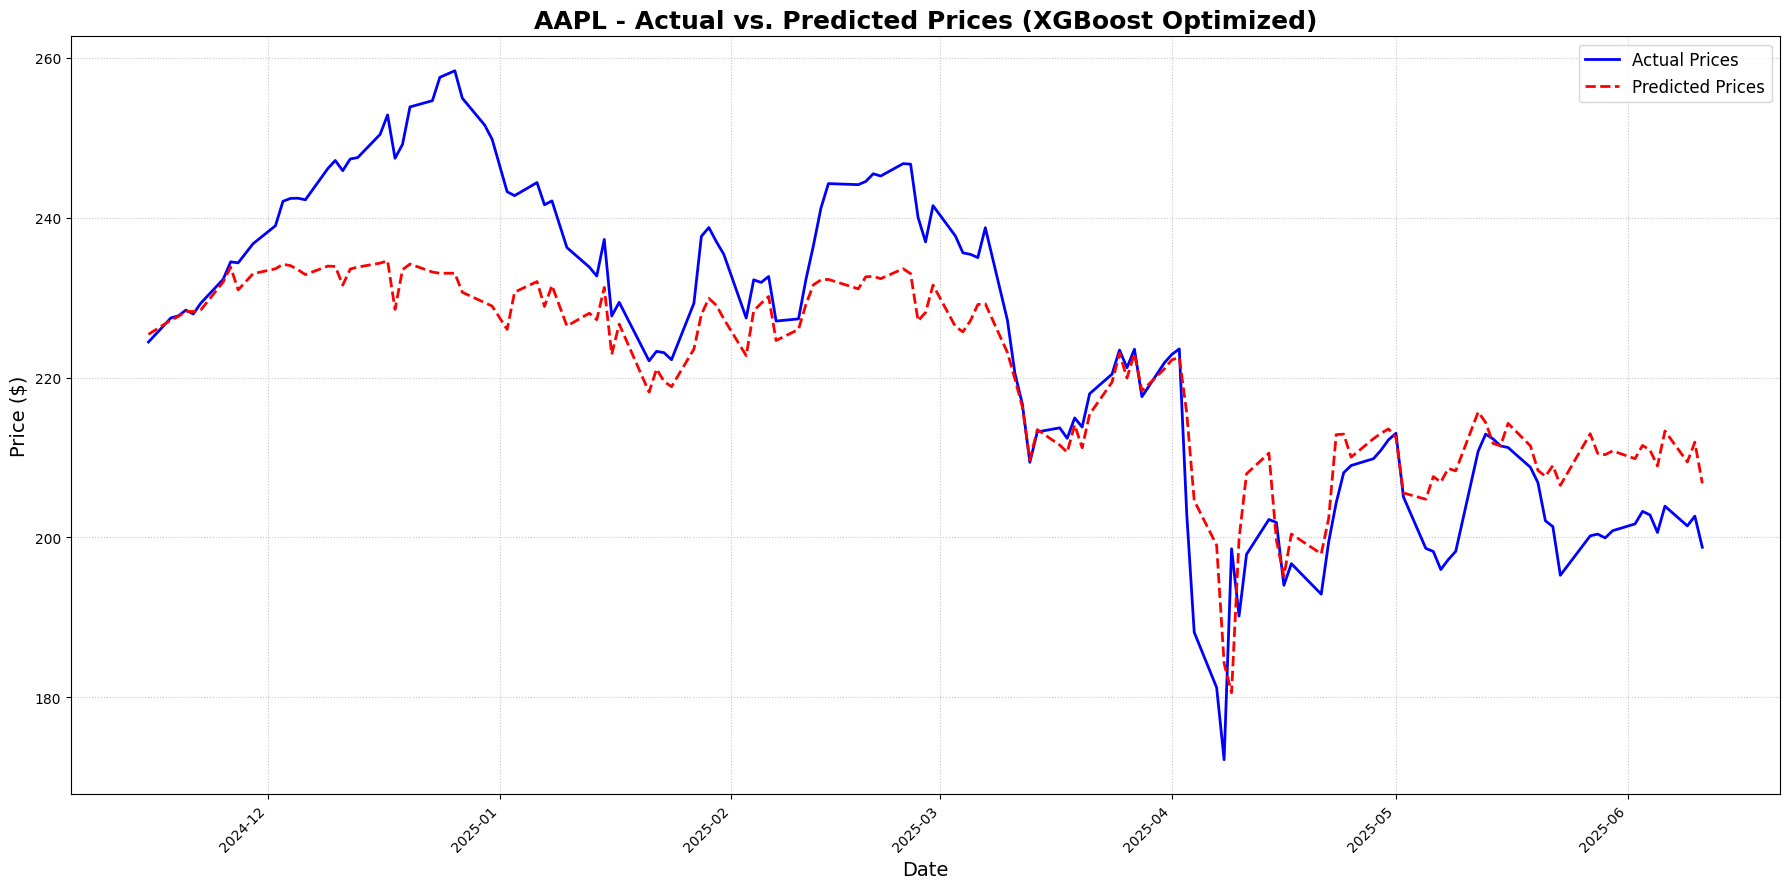


Final Performance Metrics for XGBoost (on Test Set):
  Mean Squared Error (MSE): 0.0051
  Mean Absolute Error (MAE): 0.0557
  R-squared (R2): 0.7424

 Model Evaluation Performed!


In [ ]:
print("\n Model Evaluation")
print("=" * 50)

if 'model_results' in locals() and 'trained_models' in locals() and \
   'X_test' in locals() and 'y_test' in locals() and \
   'X_test_series' in locals() and 'y_test_series' in locals() and \
   'PRIMARY_STOCK' in locals() and 'scaler_y' in locals() and scaler_y is not None and \
   'final_data' in locals():
    print(" Optimized model results and trained models available for comprehensive evaluation.")

    global BEST_MODEL, best_model_name, best_r2_score, y_test_rescaled, y_pred_best_rescaled # Make these globally available

    best_model_name = None
    best_r2_score = -float('inf')
    best_mse = float('inf')

    print("\n Comprehensive Model Performance Summary (Optimized Models):")
    for model_name, metrics in model_results.items():
        print(f"\n--- {model_name} ---")
        print(f"  MSE: {metrics['MSE']:.4f}")
        print(f"  MAE: {metrics['MAE']:.4f}")
        print(f"  R2: {metrics['R2']:.4f}")


        if metrics['R2'] > best_r2_score:
            best_r2_score = metrics['R2']
            best_mse = metrics['MSE']
            best_model_name = model_name
        elif metrics['R2'] == best_r2_score and metrics['MSE'] < best_mse:
            best_mse = metrics['MSE']
            best_model_name = model_name

    if best_model_name:
        print(f"\n Overall Best Performing Model: {best_model_name} with R2 Score: {best_r2_score:.4f} and MSE: {best_mse:.4f}.")
        BEST_MODEL = trained_models[best_model_name]
    else:
        print(" No optimized models found in 'model_results' for comparison.")
        BEST_MODEL = None

    # Visualize Best Model's Predictions vs. Actual Prices

    if BEST_MODEL is not None:
        print("\n Visualizing Best Model's Predictions on the test set:")
        try:

            if best_model_name in ['LSTM', 'CNN']:
                test_features = X_test_series
                actual_prices_scaled = y_test_series
                print(f"  Using time series data (3D) for {best_model_name} prediction.")
            else:
                test_features = X_test.values if isinstance(X_test, pd.DataFrame) else X_test
                actual_prices_scaled = y_test.values if isinstance(y_test, pd.Series) else y_test
                print(f"  Using traditional ML data (2D) for {best_model_name} prediction.")


            y_pred_best_scaled = BEST_MODEL.predict(test_features)


            if isinstance(y_pred_best_scaled, np.ndarray) and y_pred_best_scaled.ndim > 1:
                y_pred_best_scaled = y_pred_best_scaled.flatten()


            y_test_rescaled = scaler_y.inverse_transform(actual_prices_scaled.reshape(-1, 1)).flatten()
            y_pred_best_rescaled = scaler_y.inverse_transform(y_pred_best_scaled.reshape(-1, 1)).flatten()
            print("  Predictions and actual prices inverse-transformed to original scale.")


            plot_index = pd.to_datetime(final_data.index[-len(y_test_rescaled):])


            plt.figure(figsize=(18, 9))
            plt.plot(plot_index, y_test_rescaled, label='Actual Prices', color='blue', linewidth=2)
            plt.plot(plot_index, y_pred_best_rescaled, label='Predicted Prices', color='red', linestyle='--', linewidth=2)
            plt.title(f'{PRIMARY_STOCK} - Actual vs. Predicted Prices ({best_model_name} Optimized)', fontsize=18, fontweight='bold')
            plt.xlabel('Date', fontsize=14)
            plt.ylabel('Price ($)', fontsize=14)
            plt.legend(fontsize=12)
            plt.grid(True, linestyle=':', alpha=0.7)
            plt.xticks(rotation=45, ha='right', fontsize=10)
            plt.yticks(fontsize=10)
            plt.tight_layout()
            plt.show()


            print(f"\nFinal Performance Metrics for {best_model_name} (on Test Set):")
            print(f"  Mean Squared Error (MSE): {model_results[best_model_name]['MSE']:.4f}")
            print(f"  Mean Absolute Error (MAE): {model_results[best_model_name]['MAE']:.4f}")
            print(f"  R-squared (R2): {model_results[best_model_name]['R2']:.4f}")

        except Exception as e:
            print(f" Error during best model visualization: {e}")
            print("Please ensure your test data (X_test, y_test, X_test_series, y_test_series) and scaler_y are correctly defined and have consistent shapes.")
            print("Troubleshooting Tip: Check the dimensions of 'test_features' and how the model expects input.")

    else:
        print("No best model was identified or trained successfully in previous steps.")

else:
    print(" Required variables (model_results, trained_models, test data, scaler_y, etc.) not found. Please ensure Steps 1-5 are run correctly.")

print("\n" + "="*50)
print(" Model Evaluation Performed!")


In [ ]:
print("\n Iterative Training and Evaluation")
print("-" * 50)

print("This step is conceptual and depends on the performance observed in Step 6.")
print("It represents a feedback loop in the machine learning project lifecycle, allowing for refinements.")

MIN_ACCEPTABLE_R2 = 0.80

# Ensure best_r2_score is available from Step 6
if 'best_r2_score' in locals():
    print(f"Current best model's R2 Score: {best_r2_score:.4f}.")

    if best_r2_score < MIN_ACCEPTABLE_R2:
        print(f" Current best R2 ({best_r2_score:.4f}) is below the acceptable threshold ({MIN_ACCEPTABLE_R2}).")
    else:
        print(f" Model performance (R2: {best_r2_score:.4f}) is satisfactory (above {MIN_ACCEPTABLE_R2}).")
        print("The model is now ready for deployment and explainability analysis.")
else:
    print(" Best R2 score not available. Please ensure Step 6 was completed successfully.")

print("\n Step 7 Complete: Iteration Decision Made!")



 Iterative Training and Evaluation
--------------------------------------------------
This step is conceptual and depends on the performance observed in Step 6.
It represents a feedback loop in the machine learning project lifecycle, allowing for refinements.
Current best model's R2 Score: 0.7424.
 Current best R2 (0.7424) is below the acceptable threshold (0.8).

 Step 7 Complete: Iteration Decision Made!


In [ ]:
print("\n Model Deployment")
print("=" * 50)

import joblib
import os

# Ensure BEST_MODEL, feature_scaler, and scaler_y are available from previous steps
if 'BEST_MODEL' in locals() and BEST_MODEL is not None and \
   'feature_scaler' in locals() and feature_scaler is not None and \
   'scaler_y' in locals() and scaler_y is not None:
    print(" Best model and scalers identified. Preparing for deployment.")

    model_type = "unknown"
    model_save_path = ""

    try:
        # Save feature scaler
        scaler_save_path = "feature_scaler.joblib"
        joblib.dump(feature_scaler, scaler_save_path)
        print(f"  Feature scaler saved to: {scaler_save_path}.")

        # Save target scaler
        scaler_y_save_path = "target_scaler.joblib"
        joblib.dump(scaler_y, scaler_y_save_path)
        print(f"  Target scaler (for 'y') saved to: {scaler_y_save_path}.")

        # Save the best model based on its type
        if isinstance(BEST_MODEL, Sequential) or \
           (hasattr(BEST_MODEL, 'model') and isinstance(BEST_MODEL.model, Sequential)):
            model_save_path = "best_deep_learning_model.h5"
            keras_model_to_save = BEST_MODEL.model if hasattr(BEST_MODEL, 'model') else BEST_MODEL
            keras_model_to_save.save(model_save_path)
            model_type = "Deep Learning (Keras)"
        elif hasattr(BEST_MODEL, 'predict'):
            model_save_path = "best_traditional_ml_model.joblib"
            joblib.dump(BEST_MODEL, model_save_path)
            model_type = "Traditional ML (Scikit-learn/Joblib)"
        else:
            print("   Could not determine model type for saving.")
            model_save_path = None

        if model_save_path and os.path.exists(model_save_path):
            print(f"   Best model ({model_type}) saved successfully to: {model_save_path}.")
        elif model_save_path:
            print(f"   Model saving failed for {model_type}: File not found after saving attempt.")


    except Exception as e:
        print(f" Error during model saving or deployment considerations: {e}")
        print("Please ensure the BEST_MODEL object is a valid trained model and appropriate libraries (joblib, tensorflow) are installed.")

else:
    print(" No best model or scalers found to deploy. Please ensure Step 6 was completed successfully.")

print("\n  Model Deployment Considerations Outlined!")


 Model Deployment
 Best model and scalers identified. Preparing for deployment.
  Feature scaler saved to: feature_scaler.joblib.
  Target scaler (for 'y') saved to: target_scaler.joblib.
   Best model (Traditional ML (Scikit-learn/Joblib)) saved successfully to: best_traditional_ml_model.joblib.

  Model Deployment Considerations Outlined!



  Explainability
Making model predictions interpretable is crucial for building trust and providing insights, especially in financial domains.
This step involves using explainability tools like SHAP (SHapley Additive exPlanations).
 Best model, training data, test data, and feature names available for explainability analysis.

 Applying SHAP for Model Explainability:
  - Using TreeExplainer for the tree-based model.
  SHAP values calculated.


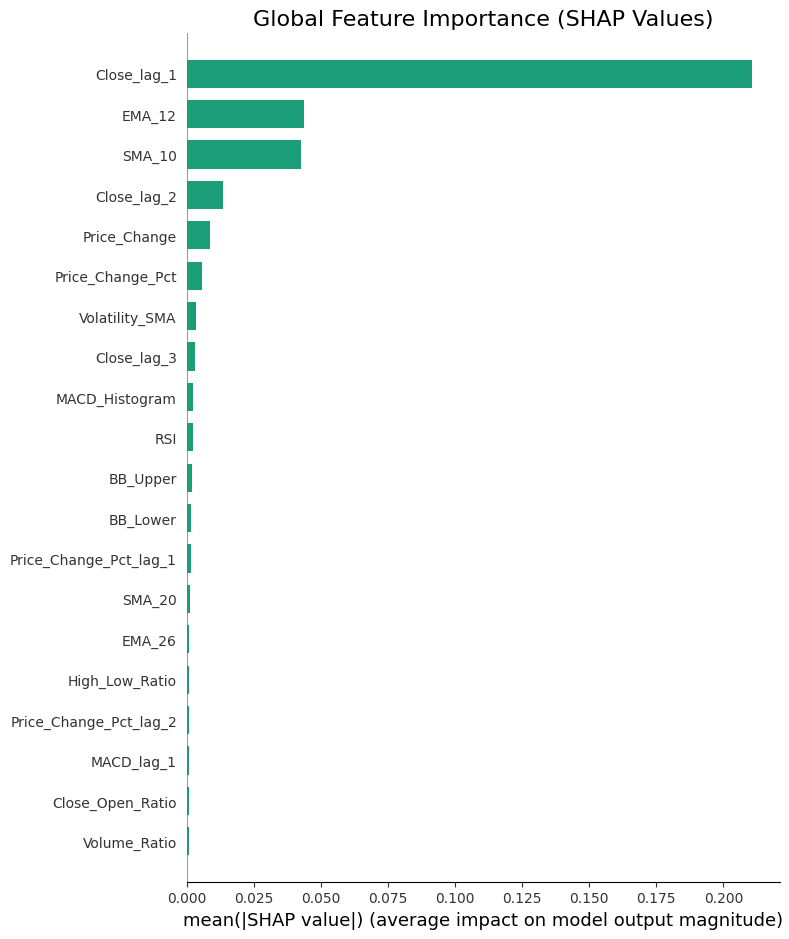

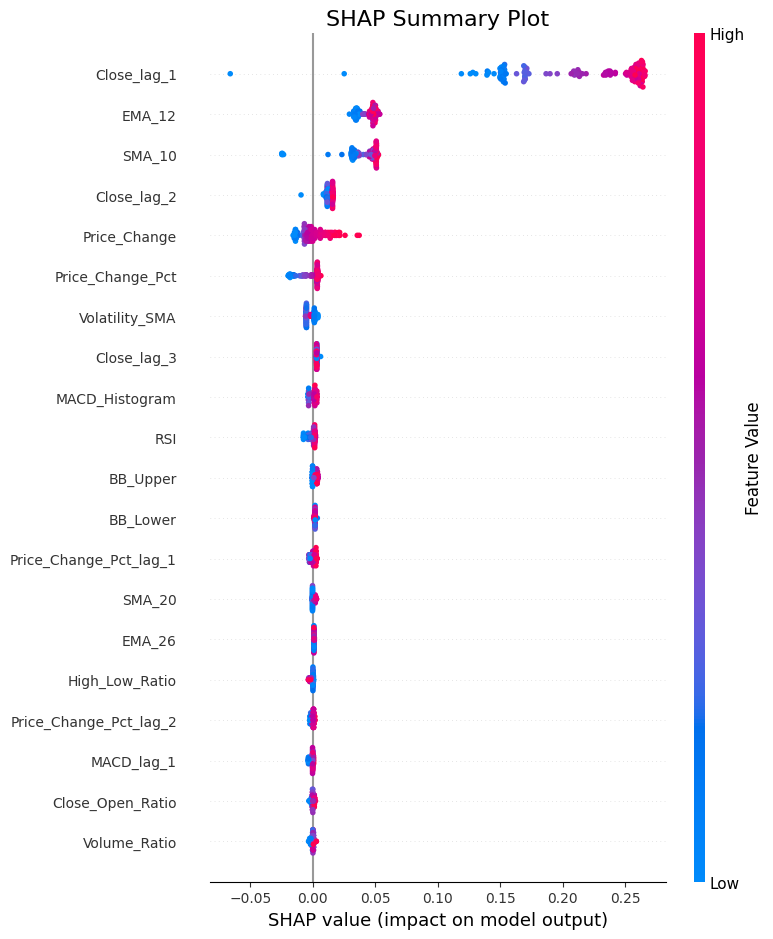


  Individual Prediction Explanation (First Test Sample - Force Plot):



 Step 9 Complete: Explainability Implemented (SHAP)!


In [ ]:
print("\n  Explainability")
print("=" * 50)

print("Making model predictions interpretable is crucial for building trust and providing insights, especially in financial domains.")
print("This step involves using explainability tools like SHAP (SHapley Additive exPlanations).")



if 'BEST_MODEL' in locals() and BEST_MODEL is not None and \
   'X_train' in locals() and 'X_test' in locals() and \
   'feature_names' in locals() and 'X_train_series' in locals() and 'X_test_series' in locals():
    print(" Best model, training data, test data, and feature names available for explainability analysis.")

    try:

        if X_train.shape[0] > 1000:
            background_data_for_shap_traditional = X_train.sample(n=500, random_state=42)
        else:
            background_data_for_shap_traditional = X_train


        if X_train_series.shape[0] > 1000:

            random_indices = np.random.choice(X_train_series.shape[0], 500, replace=False)
            background_data_for_shap_dl = X_train_series[random_indices]
        else:
            background_data_for_shap_dl = X_train_series

        print("\n Applying SHAP for Model Explainability:")


        if isinstance(BEST_MODEL, Sequential) or \
           (hasattr(BEST_MODEL, 'model') and isinstance(BEST_MODEL.model, Sequential)):

            print("  - Using DeepExplainer for the deep learning model.")


            keras_model_for_shap = BEST_MODEL.model if hasattr(BEST_MODEL, 'model') else BEST_MODEL


            shap_values_dl = []

            batch_size = 500
            for i in range(0, X_test_series.shape[0], batch_size):
                shap_values_dl.append(explainer.shap_values(X_test_series[i:i + batch_size]))


            if isinstance(shap_values_dl[0], list):
                shap_values_dl = np.concatenate([s[0] for s in shap_values_dl], axis=0)
            else:
                shap_values_dl = np.concatenate(shap_values_dl, axis=0)


            print("  SHAP values calculated for the Deep Learning model.")

            avg_shap_values = np.mean(shap_values_dl, axis=1)

            dummy_X_test_df = pd.DataFrame(X_test_series[:, -1, :], columns=feature_names)

            plt.figure(figsize=(12, 8))
            shap.summary_plot(avg_shap_values, dummy_X_test_df, plot_type="bar", show=False, color='#2c7bb6')
            plt.title("Global Feature Importance (SHAP Values) - Deep Learning (Averaged)", fontsize=16)
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)
            plt.tight_layout()
            plt.show()

            plt.figure(figsize=(14, 9))
            shap.summary_plot(avg_shap_values, dummy_X_test_df, show=False, plot_type="dot", color_bar=True, color_bar_label="Feature Value")
            plt.title("SHAP Summary Plot - Deep Learning (Averaged)", fontsize=16)
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)
            plt.tight_layout()
            plt.show()

            print("\n  Note: Individual prediction explanations (force plots) for deep learning models with sequential data require more specific handling of time series SHAP values.")


        elif hasattr(BEST_MODEL, 'feature_importances_') or isinstance(BEST_MODEL, (XGBRegressor, SVR)):
            if isinstance(BEST_MODEL, (XGBRegressor)): # Tree-based models
                print("  - Using TreeExplainer for the tree-based model.")
                explainer = shap.TreeExplainer(BEST_MODEL)
            else: # For SVM, use KernelExplainer
                print("  - Using KernelExplainer for the SVM model (can be slow for large datasets).")
                explainer = shap.KernelExplainer(BEST_MODEL.predict, background_data_for_shap_traditional)


            X_test_df = X_test.copy() if isinstance(X_test, pd.DataFrame) else pd.DataFrame(X_test, columns=feature_names)


            # Calculate SHAP values
            shap_values = explainer.shap_values(X_test_df)
            print("  SHAP values calculated.")

            # Visualize global feature importance (bar plot)
            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_values, X_test_df, plot_type="bar", show=False, color='#1b9e77')
            plt.title("Global Feature Importance (SHAP Values)", fontsize=16)
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)
            plt.tight_layout()
            plt.show()

            plt.figure(figsize=(14, 9))
            shap.summary_plot(shap_values, X_test_df, show=False, plot_type="dot", color_bar=True, color_bar_label="Feature Value")
            plt.title("SHAP Summary Plot", fontsize=16)
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)
            plt.tight_layout()
            plt.show()

            print("\n  Individual Prediction Explanation (First Test Sample - Force Plot):")
            shap.initjs()

            if isinstance(explainer.expected_value, np.ndarray) and explainer.expected_value.ndim > 0:
                 expected_value_single = explainer.expected_value[0] if explainer.expected_value.ndim > 0 else explainer.expected_value
            else:
                 expected_value_single = explainer.expected_value
            display(shap.force_plot(expected_value_single, shap_values[0,:], X_test_df.iloc[0,:]))

        else:
            print("  Explainability for this model type is not explicitly covered here with SHAP. Consider using KernelExplainer directly if applicable.")

    except ImportError:
        print(" SHAP library not installed. Please ensure you ran `!pip install shap` in the Project Setup block.")
    except Exception as e:
        print(f" Error during SHAP explainability: {e}")
        print("Please ensure your data (X_test, X_train, feature_names, X_test_series, X_train_series) is correctly formatted and matches the model's input expectations.")
        print("For DeepExplainer, ensure X_train_series/X_test_series are 3D (samples, timesteps, features).")

else:
    print(" Required variables (BEST_MODEL, X_train, X_test, feature_names, X_train_series, X_test_series) not found. Please ensure Step 6 and relevant preceding steps are completed.")

print("\n Step 9 Complete: Explainability Implemented (SHAP)!")



 Step 10: Investor Dashboards
 Actual and predicted (rescaled) prices available for dashboard visualization.


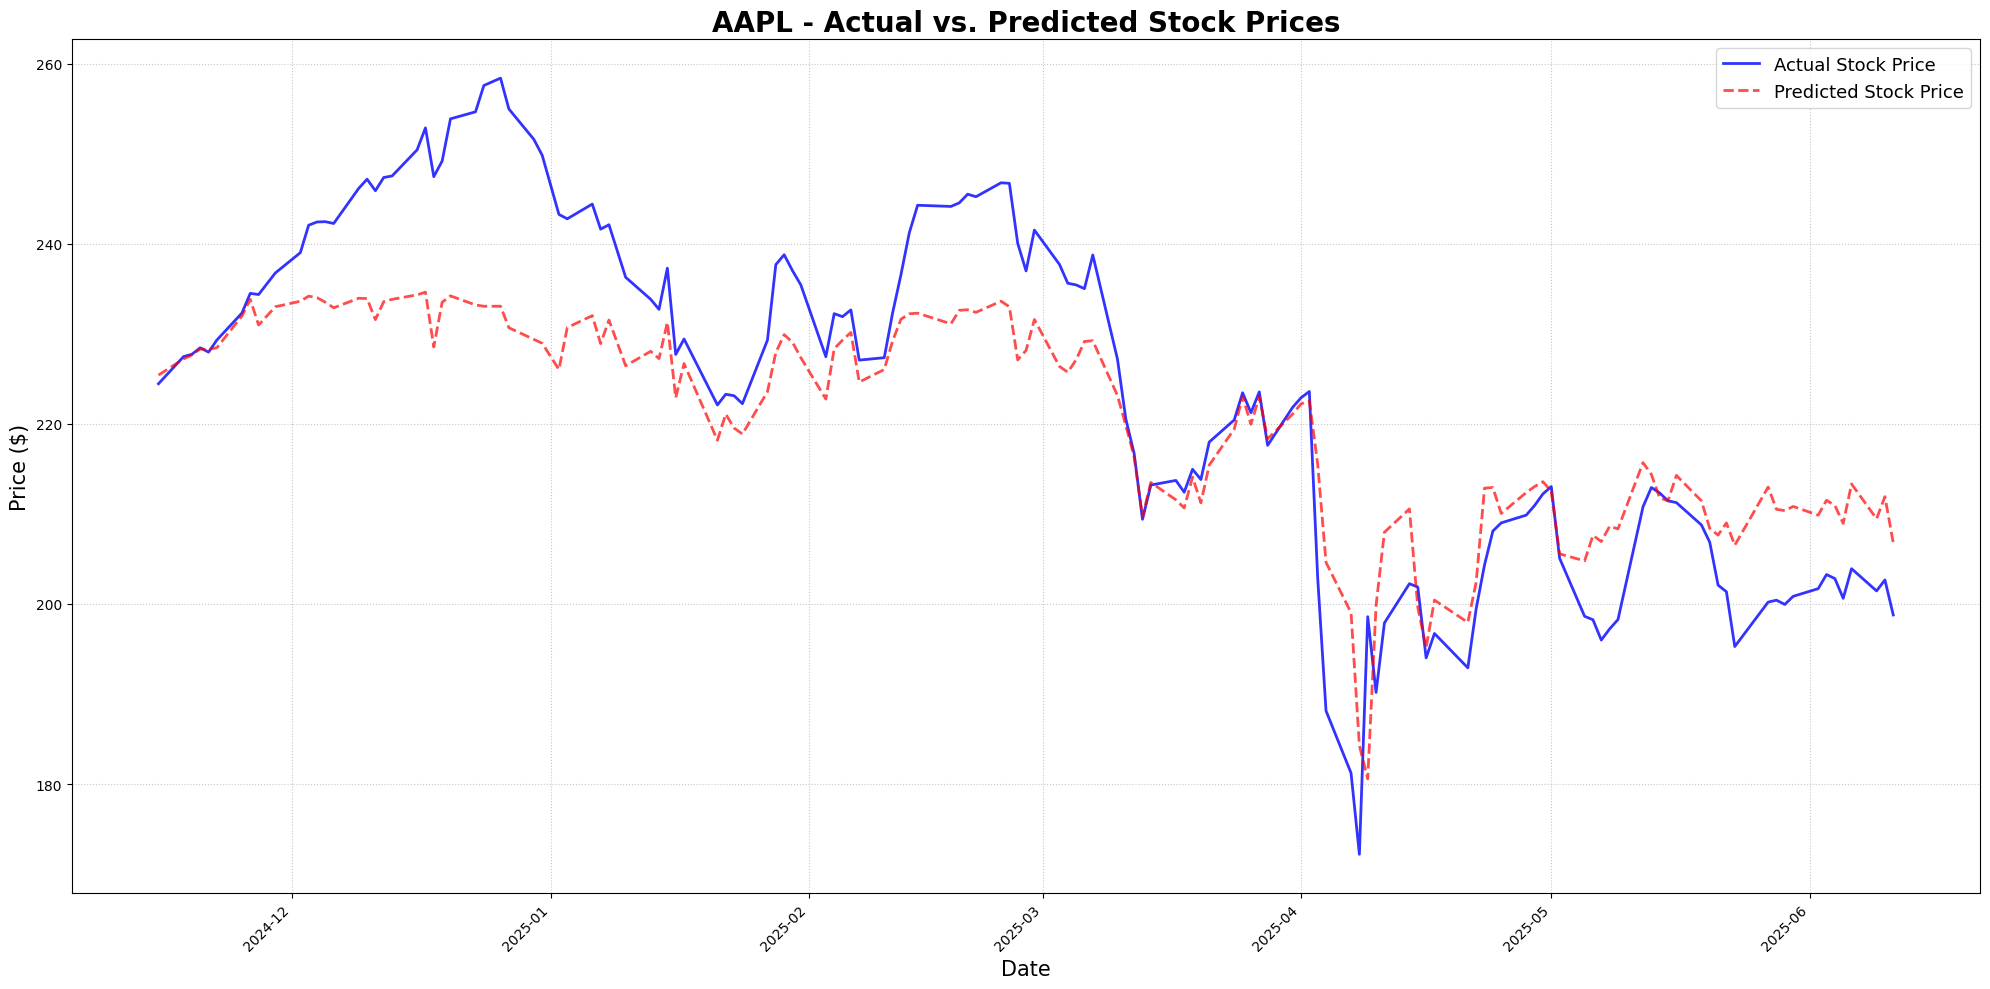

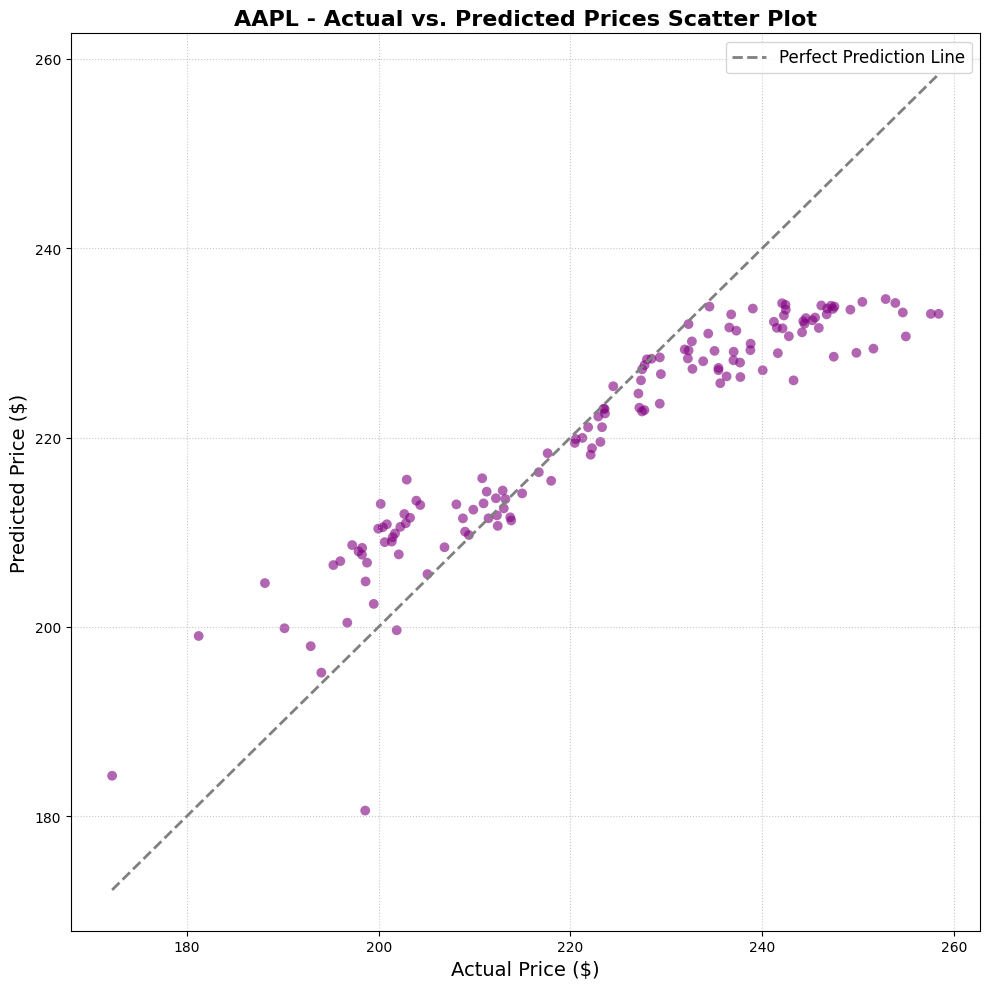

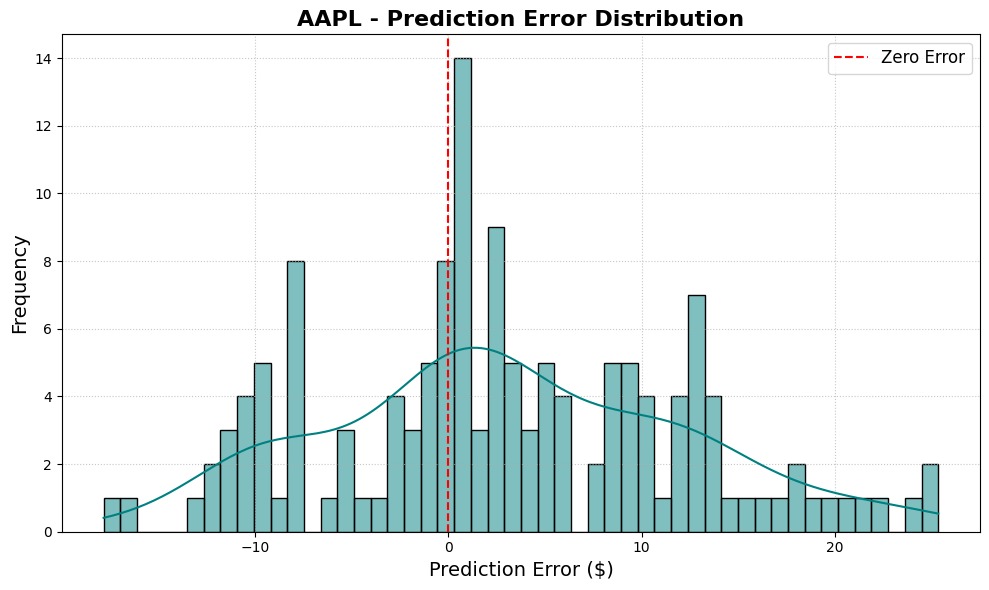

In [ ]:
print("\n Step 10: Investor Dashboards")
print("=" * 50)

if 'y_test_rescaled' in locals() and 'y_pred_best_rescaled' in locals() and \
   'PRIMARY_STOCK' in locals() and 'final_data' in locals():
    print(" Actual and predicted (rescaled) prices available for dashboard visualization.")

    plot_index_test = pd.to_datetime(final_data.index[-len(y_test_rescaled):])

    # Dashboard Component 1: Actual vs. Predicted Prices Over Time
    plt.figure(figsize=(20, 10))
    plt.plot(plot_index_test, y_test_rescaled, label='Actual Stock Price', color='blue', linewidth=2, alpha=0.8)
    plt.plot(plot_index_test, y_pred_best_rescaled, label='Predicted Stock Price', color='red', linestyle='--', linewidth=2, alpha=0.7)
    plt.title(f'{PRIMARY_STOCK} - Actual vs. Predicted Stock Prices', fontsize=20, fontweight='bold')
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Price ($)', fontsize=15)
    plt.legend(fontsize=13)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

    # Dashboard Component 2: Predicted vs. Actual Scatter Plot (for visualizing correlation)
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test_rescaled, y_pred_best_rescaled, alpha=0.6, color='purple', s=50, edgecolors='none') # Added size and edgecolors
    # Plot a perfect prediction line (y=x)
    min_val = min(y_test_rescaled.min(), y_pred_best_rescaled.min())
    max_val = max(y_test_rescaled.max(), y_pred_best_rescaled.max())
    plt.plot([min_val, max_val], [min_val, max_val],
             linestyle='--', color='gray', linewidth=2, label='Perfect Prediction Line')
    plt.title(f'{PRIMARY_STOCK} - Actual vs. Predicted Prices Scatter Plot', fontsize=16, fontweight='bold')
    plt.xlabel('Actual Price ($)', fontsize=14)
    plt.ylabel('Predicted Price ($)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

    # Dashboard Component 3: Prediction Error Distribution
    prediction_errors = y_test_rescaled - y_pred_best_rescaled
    plt.figure(figsize=(10, 6))
    sns.histplot(prediction_errors, bins=50, kde=True, color='teal', edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', label='Zero Error')
    plt.title(f'{PRIMARY_STOCK} - Prediction Error Distribution', fontsize=16, fontweight='bold')
    plt.xlabel('Prediction Error ($)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()


else:
    print(" Not enough data (y_test_rescaled, y_pred_best_rescaled) to generate dashboard visualizations. Please ensure Step 6 was completed successfully.")